In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
HDAC6 = Path(HERE).resolve().parents[1]/'input'

In [3]:
df = pd.read_pickle(HDAC6/"HDAC6_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC6
0,CHEMBL4084049,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2631951, 2609298, 137380, 7125875, 28861, 361...",6.26
1,CHEMBL2178343,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[42543, 4438892, 868377, 13268142, 10609042, 2...",5.96
2,CHEMBL454672,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[18278628, 736579, 8934602, 21013631, 1468176,...",6.80
3,CHEMBL4299417,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100053, 10511, 1733887, 904525, 692898, 28201...",8.14
4,CHEMBL3692580,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2532187, 6225575, 4703614, 6282372, 14228323,...",5.24


In [4]:
df_labeled = pd.read_csv(HDAC6/"HDAC6_dataset.csv",)
df_labeled

,molecule_chembl_id,smiles,type,Standard_Value_HDAC6,pChEMBL_HDAC6,label
0,CHEMBL4082520,CN1C(=O)C2CN(Cc3c2c2cc(OCc4ccccc4)ccc2n3Cc2ccc...,Ki,0.08,10.10,Single points
1,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,IC50,0.14,9.85,HDAC6-selective
2,CHEMBL4100534,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,Ki,0.15,9.82,Single points
3,CHEMBL4101480,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,Ki,0.16,9.80,Single points
4,CHEMBL3912061,CS(=O)(=O)NCCc1cn(Cc2ccc(C(=O)NO)cc2)c2ccccc12,IC50,0.17,9.77,HDAC6-selective
...,...,...,...,...,...,...
2966,CHEMBL1798006,CC[C@H](C)[C@H](NC(=O)C1CCNCC1)C(=O)N1Cc2cc(OC...,IC50,169.00,6.77,Single points
2967,CHEMBL470843,O=C(/C=C/c1ccc(-c2cc(CN3CCOCC3)on2)cc1)NO,IC50,175.00,6.76,Semi-selective
2968,CHEMBL1798004,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N1Cc2c...,IC50,191.00,6.72,Single points
2969,CHEMBL3215861,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC,Ki,247.00,6.61,Dual-binder


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')
df.head()

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC6,label
0,CHEMBL4084049,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2631951, 2609298, 137380, 7125875, 28861, 361...",6.26,Single points
1,CHEMBL2178343,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[42543, 4438892, 868377, 13268142, 10609042, 2...",5.96,Single points
2,CHEMBL454672,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[18278628, 736579, 8934602, 21013631, 1468176,...",6.80,Semi-selective
3,CHEMBL4299417,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100053, 10511, 1733887, 904525, 692898, 28201...",8.14,Dual-binder
4,CHEMBL3692580,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2532187, 6225575, 4703614, 6282372, 14228323,...",5.24,Single points


In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC6,label,Class
0,CHEMBL4084049,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2631951, 2609298, 137380, 7125875, 28861, 361...",6.26,Single points,0.0
1,CHEMBL2178343,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[42543, 4438892, 868377, 13268142, 10609042, 2...",5.96,Single points,0.0
2,CHEMBL454672,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[18278628, 736579, 8934602, 21013631, 1468176,...",6.80,Semi-selective,5.0
3,CHEMBL4299417,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100053, 10511, 1733887, 904525, 692898, 28201...",8.14,Dual-binder,3.0


In [7]:
# Add column for activity
df["activity"] = np.zeros(len(df))

# Mark every molecule as active if pChEMBL_HDAC6 value is >=6.6 0 otherwise
df.loc[df[df.pChEMBL_HDAC6 >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y = df["pChEMBL_HDAC6"].values
Y_cat =  df["activity"].values
Y_class = df['Class'].values
indices =  np.array(df.index)


In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['pChEMBL_HDAC6'])).astype(float)
    globals_dict[f"Y_trainSet{i}_cat"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['pChEMBL_HDAC6'])).astype(float)
    globals_dict[f"Y_testSet{i}_cat"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_reg =  RandomForestRegressor(random_state=1121218, max_features = None, n_jobs=8,oob_score=True,
                                           max_samples=0.8, )
        rf_reg.fit(x_train, y_train)
        y_pred = rf_reg.predict(x_test)  
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6) , 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)



mat_met_rf = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    R2         0.691480     0.025589
1                    TP       164.800000    11.213088
2                    TN        89.000000     6.616478
3                    FP        24.400000     4.550946
4                    FN        18.900000     5.896327
5              Accuracy         0.854262     0.031203
6             Precision         0.870435     0.027507
7           Sensitivity         0.896454     0.035669
8           Specificity         0.785070     0.035944
9              F1 score         0.883109     0.029392
10  F1 score (weighted)         0.853511     0.031112
11     F1 score (macro)         0.843952     0.031070
12    Balanced Accuracy         0.840759     0.030357
13                  MCC         0.689070     0.062542
14                  NPV         0.826330     0.043867
15              ROC_AUC         0.840759     0.030357
CPU times: user 2min 20s, sys: 250 ms, total: 2min 21s
Wall time: 20.2 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestRegressor(**param_grid, n_jobs=8, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestRegressor(**param_grid, n_jobs=8, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFRegressor")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 15:46:09,183] A new study created in memory with name: RFRegressor
[I 2023-12-19 15:47:23,478] Trial 0 finished with value: 0.6684480541622599 and parameters: {'n_estimators': 463}. Best is trial 0 with value: 0.6684480541622599.
[I 2023-12-19 15:50:12,175] Trial 1 finished with value: 0.6690088074637214 and parameters: {'n_estimators': 957}. Best is trial 1 with value: 0.6690088074637214.
[I 2023-12-19 15:52:48,603] Trial 2 finished with value: 0.6690400225631468 and parameters: {'n_estimators': 754}. Best is trial 2 with value: 0.6690400225631468.
[I 2023-12-19 15:54:04,443] Trial 3 finished with value: 0.6681229338474395 and parameters: {'n_estimators': 351}. Best is trial 2 with value: 0.6690400225631468.
[I 2023-12-19 15:57:32,173] Trial 4 finished with value: 0.668984909599482 and parameters: {'n_estimators': 983}. Best is trial 2 with value: 0.6690400225631468.
[I 2023-12-19 15:59:28,988] Trial 5 finished with value: 0.6684805313880693 and parameters: {'n_estimator

	Number of trials: 50.0
	Best value (r2_score): 0.6692
	Best params:
		n_estimators: 730


In [14]:
optimized_rf_0 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_rf_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_0_cat = np.where((y_pred_rf_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_rf_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_rf_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_rf_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_rf_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_rf_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_rf_0_cat)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    R2    0.701707
1                    TP  345.000000
2                    TN  170.000000
3                    FP   42.000000
4                    FN   38.000000
5              Accuracy    0.865546
6             Precision    0.891473
7           Sensitivity    0.900783
8           Specificity    0.801900
9              F1 score    0.896104
10  F1 score (weighted)    0.865255
11     F1 score (macro)    0.852814
12    Balanced Accuracy    0.851335
13                  MCC    0.705719
14                  NPV    0.817300
15              ROC_AUC    0.851335


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 17:46:48,442] Trial 50 finished with value: 0.6707941325526378 and parameters: {'n_estimators': 569}. Best is trial 50 with value: 0.6707941325526378.
[I 2023-12-19 17:48:42,275] Trial 51 finished with value: 0.6707617402922468 and parameters: {'n_estimators': 568}. Best is trial 50 with value: 0.6707941325526378.
[I 2023-12-19 17:50:44,877] Trial 52 finished with value: 0.6708063351000184 and parameters: {'n_estimators': 561}. Best is trial 52 with value: 0.6708063351000184.
[I 2023-12-19 17:52:08,701] Trial 53 finished with value: 0.670289646680386 and parameters: {'n_estimators': 406}. Best is trial 52 with value: 0.6708063351000184.
[I 2023-12-19 17:53:36,357] Trial 54 finished with value: 0.6704915005116191 and parameters: {'n_estimators': 419}. Best is trial 52 with value: 0.6708063351000184.
[I 2023-12-19 17:55:00,813] Trial 55 finished with value: 0.6701961072285 and parameters: {'n_estimators': 399}. Best is trial 52 with value: 0.6708063351000184.
[I 2023-12-19 

	Number of trials: 100.0
	Best value (r2_score): 0.6712
	Best params:
		n_estimators: 638


In [16]:
optimized_rf_1 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_rf_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_1_cat = np.where((y_pred_rf_1 >= 6.6), 1, 0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_rf_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_rf_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_rf_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_rf_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_rf_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_rf_1_cat)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    R2    0.701707    0.700515
1                    TP  345.000000  333.000000
2                    TN  170.000000  182.000000
3                    FP   42.000000   48.000000
4                    FN   38.000000   32.000000
5              Accuracy    0.865546    0.865546
6             Precision    0.891473    0.874016
7           Sensitivity    0.900783    0.912329
8           Specificity    0.801900    0.791300
9              F1 score    0.896104    0.892761
10  F1 score (weighted)    0.865255    0.864565
11     F1 score (macro)    0.852814    0.856291
12    Balanced Accuracy    0.851335    0.851817
13                  MCC    0.705719    0.713982
14                  NPV    0.817300    0.850500
15              ROC_AUC    0.851335    0.851817


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 19:28:17,276] Trial 100 finished with value: 0.6815378035463577 and parameters: {'n_estimators': 761}. Best is trial 100 with value: 0.6815378035463577.
[I 2023-12-19 19:30:55,225] Trial 101 finished with value: 0.6815365061516063 and parameters: {'n_estimators': 809}. Best is trial 100 with value: 0.6815378035463577.
[I 2023-12-19 19:33:34,476] Trial 102 finished with value: 0.6816145660536908 and parameters: {'n_estimators': 797}. Best is trial 102 with value: 0.6816145660536908.
[I 2023-12-19 19:36:16,689] Trial 103 finished with value: 0.6815202442860991 and parameters: {'n_estimators': 808}. Best is trial 102 with value: 0.6816145660536908.
[I 2023-12-19 19:39:00,454] Trial 104 finished with value: 0.6815207067829708 and parameters: {'n_estimators': 817}. Best is trial 102 with value: 0.6816145660536908.
[I 2023-12-19 19:41:41,117] Trial 105 finished with value: 0.6815924841283003 and parameters: {'n_estimators': 803}. Best is trial 102 with value: 0.6816145660536908

	Number of trials: 150.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [18]:

optimized_rf_2 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_rf_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_2_cat = np.where((y_pred_rf_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_rf_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_rf_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_rf_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_rf_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_rf_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_rf_2_cat)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.701707    0.700515    0.676903
1                    TP  345.000000  333.000000  339.000000
2                    TN  170.000000  182.000000  167.000000
3                    FP   42.000000   48.000000   55.000000
4                    FN   38.000000   32.000000   34.000000
5              Accuracy    0.865546    0.865546    0.850420
6             Precision    0.891473    0.874016    0.860406
7           Sensitivity    0.900783    0.912329    0.908847
8           Specificity    0.801900    0.791300    0.752300
9              F1 score    0.896104    0.892761    0.883963
10  F1 score (weighted)    0.865255    0.864565    0.848755
11     F1 score (macro)    0.852814    0.856291    0.836781
12    Balanced Accuracy    0.851335    0.851817    0.830550
13                  MCC    0.705719    0.713982    0.676008
14                  NPV    0.817300    0.850500    0.830800
15              ROC_AUC    0.851335    0

In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 21:55:56,206] Trial 150 finished with value: 0.6728330462871506 and parameters: {'n_estimators': 999}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-19 21:59:03,938] Trial 151 finished with value: 0.6727642742980273 and parameters: {'n_estimators': 960}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-19 22:02:11,310] Trial 152 finished with value: 0.6727752413832462 and parameters: {'n_estimators': 964}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-19 22:05:19,807] Trial 153 finished with value: 0.6728911606790416 and parameters: {'n_estimators': 982}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-19 22:08:24,644] Trial 154 finished with value: 0.6726961575395622 and parameters: {'n_estimators': 946}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-19 22:11:28,569] Trial 155 finished with value: 0.6727060319535261 and parameters: {'n_estimators': 941}. Best is trial 149 with value: 0.6819404343724317

	Number of trials: 200.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [20]:
optimized_rf_3 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_rf_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_3_cat = np.where((y_pred_rf_3 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_rf_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_rf_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_rf_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_rf_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_rf_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_rf_3_cat)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.701707    0.700515    0.676903    0.718249
1                    TP  345.000000  333.000000  339.000000  336.000000
2                    TN  170.000000  182.000000  167.000000  174.000000
3                    FP   42.000000   48.000000   55.000000   52.000000
4                    FN   38.000000   32.000000   34.000000   33.000000
5              Accuracy    0.865546    0.865546    0.850420    0.857143
6             Precision    0.891473    0.874016    0.860406    0.865979
7           Sensitivity    0.900783    0.912329    0.908847    0.910569
8           Specificity    0.801900    0.791300    0.752300    0.769900
9              F1 score    0.896104    0.892761    0.883963    0.887715
10  F1 score (weighted)    0.865255    0.864565    0.848755    0.855801
11     F1 score (macro)    0.852814    0.856291    0.836781    0.845705
12    Balanced Accuracy    0.851335    0.851817    0.830550    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:22:21,098] Trial 200 finished with value: 0.6762553340276423 and parameters: {'n_estimators': 849}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 00:24:55,038] Trial 201 finished with value: 0.6761521643861699 and parameters: {'n_estimators': 925}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 00:27:22,538] Trial 202 finished with value: 0.6761811425353205 and parameters: {'n_estimators': 891}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 00:30:05,951] Trial 203 finished with value: 0.6761150464509045 and parameters: {'n_estimators': 969}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 00:32:38,283] Trial 204 finished with value: 0.6761402498595366 and parameters: {'n_estimators': 930}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 00:35:24,830] Trial 205 finished with value: 0.6762708876595058 and parameters: {'n_estimators': 1000}. Best is trial 149 with value: 0.681940434372431

	Number of trials: 250.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [22]:
optimized_rf_4 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_rf_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_4_cat = np.where((y_pred_rf_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_rf_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_rf_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_rf_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_rf_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_rf_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_rf_4_cat)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.701707    0.700515    0.676903    0.718249   
1                    TP  345.000000  333.000000  339.000000  336.000000   
2                    TN  170.000000  182.000000  167.000000  174.000000   
3                    FP   42.000000   48.000000   55.000000   52.000000   
4                    FN   38.000000   32.000000   34.000000   33.000000   
5              Accuracy    0.865546    0.865546    0.850420    0.857143   
6             Precision    0.891473    0.874016    0.860406    0.865979   
7           Sensitivity    0.900783    0.912329    0.908847    0.910569   
8           Specificity    0.801900    0.791300    0.752300    0.769900   
9              F1 score    0.896104    0.892761    0.883963    0.887715   
10  F1 score (weighted)    0.865255    0.864565    0.848755    0.855801   
11     F1 score (macro)    0.852814    0.856291    0.836781    0.845705   
12    Balanced Accuracy  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 02:28:22,967] Trial 250 finished with value: 0.6678566310796008 and parameters: {'n_estimators': 929}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 02:30:49,933] Trial 251 finished with value: 0.6678634685931628 and parameters: {'n_estimators': 955}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 02:33:10,885] Trial 252 finished with value: 0.6679753621893405 and parameters: {'n_estimators': 910}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 02:35:28,053] Trial 253 finished with value: 0.6678492883451326 and parameters: {'n_estimators': 886}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 02:37:56,406] Trial 254 finished with value: 0.6678273971715203 and parameters: {'n_estimators': 986}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 02:40:22,924] Trial 255 finished with value: 0.6677938662024976 and parameters: {'n_estimators': 948}. Best is trial 149 with value: 0.6819404343724317

	Number of trials: 300.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [24]:
optimized_rf_5 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_rf_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_5_cat = np.where((y_pred_rf_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_rf_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_rf_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_rf_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_rf_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_rf_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_rf_5_cat)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.701707    0.700515    0.676903    0.718249   
1                    TP  345.000000  333.000000  339.000000  336.000000   
2                    TN  170.000000  182.000000  167.000000  174.000000   
3                    FP   42.000000   48.000000   55.000000   52.000000   
4                    FN   38.000000   32.000000   34.000000   33.000000   
5              Accuracy    0.865546    0.865546    0.850420    0.857143   
6             Precision    0.891473    0.874016    0.860406    0.865979   
7           Sensitivity    0.900783    0.912329    0.908847    0.910569   
8           Specificity    0.801900    0.791300    0.752300    0.769900   
9              F1 score    0.896104    0.892761    0.883963    0.887715   
10  F1 score (weighted)    0.865255    0.864565    0.848755    0.855801   
11     F1 score (macro)    0.852814    0.856291    0.836781    0.845705   
12    Balanced Accuracy  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 04:25:50,718] Trial 300 finished with value: 0.6688723272516598 and parameters: {'n_estimators': 967}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 04:26:32,229] Trial 301 finished with value: 0.6664618891644787 and parameters: {'n_estimators': 273}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 04:29:08,804] Trial 302 finished with value: 0.6688728761488456 and parameters: {'n_estimators': 998}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 04:31:36,960] Trial 303 finished with value: 0.6685190037158563 and parameters: {'n_estimators': 942}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 04:34:03,361] Trial 304 finished with value: 0.6684635997282679 and parameters: {'n_estimators': 919}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 04:36:19,832] Trial 305 finished with value: 0.6682892775616229 and parameters: {'n_estimators': 883}. Best is trial 149 with value: 0.6819404343724317

	Number of trials: 350.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [26]:
optimized_rf_6 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_rf_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_6_cat = np.where((y_pred_rf_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_rf_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_rf_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_rf_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_rf_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_rf_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_rf_6_cat)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.701707    0.700515    0.676903    0.718249   
1                    TP  345.000000  333.000000  339.000000  336.000000   
2                    TN  170.000000  182.000000  167.000000  174.000000   
3                    FP   42.000000   48.000000   55.000000   52.000000   
4                    FN   38.000000   32.000000   34.000000   33.000000   
5              Accuracy    0.865546    0.865546    0.850420    0.857143   
6             Precision    0.891473    0.874016    0.860406    0.865979   
7           Sensitivity    0.900783    0.912329    0.908847    0.910569   
8           Specificity    0.801900    0.791300    0.752300    0.769900   
9              F1 score    0.896104    0.892761    0.883963    0.887715   
10  F1 score (weighted)    0.865255    0.864565    0.848755    0.855801   
11     F1 score (macro)    0.852814    0.856291    0.836781    0.845705   
12    Balanced Accuracy  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 06:22:46,812] Trial 350 finished with value: 0.6808030924405266 and parameters: {'n_estimators': 916}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 06:24:48,984] Trial 351 finished with value: 0.6808431103947848 and parameters: {'n_estimators': 935}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 06:26:57,939] Trial 352 finished with value: 0.6810314066776807 and parameters: {'n_estimators': 970}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 06:28:56,652] Trial 353 finished with value: 0.6808754049931609 and parameters: {'n_estimators': 898}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 06:30:57,407] Trial 354 finished with value: 0.6808446816965411 and parameters: {'n_estimators': 944}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 06:32:57,940] Trial 355 finished with value: 0.6807836009258581 and parameters: {'n_estimators': 923}. Best is trial 149 with value: 0.6819404343724317

	Number of trials: 400.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [28]:
optimized_rf_7 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_rf_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_7_cat = np.where((y_pred_rf_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_rf_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_rf_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_rf_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_rf_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_rf_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_rf_7_cat)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.701707    0.700515    0.676903    0.718249   
1                    TP  345.000000  333.000000  339.000000  336.000000   
2                    TN  170.000000  182.000000  167.000000  174.000000   
3                    FP   42.000000   48.000000   55.000000   52.000000   
4                    FN   38.000000   32.000000   34.000000   33.000000   
5              Accuracy    0.865546    0.865546    0.850420    0.857143   
6             Precision    0.891473    0.874016    0.860406    0.865979   
7           Sensitivity    0.900783    0.912329    0.908847    0.910569   
8           Specificity    0.801900    0.791300    0.752300    0.769900   
9              F1 score    0.896104    0.892761    0.883963    0.887715   
10  F1 score (weighted)    0.865255    0.864565    0.848755    0.855801   
11     F1 score (macro)    0.852814    0.856291    0.836781    0.845705   
12    Balanced Accuracy  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 08:03:31,559] Trial 400 finished with value: 0.6732059795794759 and parameters: {'n_estimators': 971}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 08:05:35,612] Trial 401 finished with value: 0.6732668230804988 and parameters: {'n_estimators': 917}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 08:07:41,813] Trial 402 finished with value: 0.6731671183494086 and parameters: {'n_estimators': 940}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 08:09:48,221] Trial 403 finished with value: 0.6732179808647143 and parameters: {'n_estimators': 960}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 08:11:44,210] Trial 404 finished with value: 0.6731838280831571 and parameters: {'n_estimators': 862}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 08:13:40,876] Trial 405 finished with value: 0.673143344561125 and parameters: {'n_estimators': 893}. Best is trial 149 with value: 0.6819404343724317.

	Number of trials: 450.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [30]:
optimized_rf_8 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_rf_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_8_cat = np.where((y_pred_rf_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_rf_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_rf_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_rf_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_rf_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_rf_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_rf_8_cat)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.701707    0.700515    0.676903    0.718249   
1                    TP  345.000000  333.000000  339.000000  336.000000   
2                    TN  170.000000  182.000000  167.000000  174.000000   
3                    FP   42.000000   48.000000   55.000000   52.000000   
4                    FN   38.000000   32.000000   34.000000   33.000000   
5              Accuracy    0.865546    0.865546    0.850420    0.857143   
6             Precision    0.891473    0.874016    0.860406    0.865979   
7           Sensitivity    0.900783    0.912329    0.908847    0.910569   
8           Specificity    0.801900    0.791300    0.752300    0.769900   
9              F1 score    0.896104    0.892761    0.883963    0.887715   
10  F1 score (weighted)    0.865255    0.864565    0.848755    0.855801   
11     F1 score (macro)    0.852814    0.856291    0.836781    0.845705   
12    Balanced Accuracy  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 09:41:45,499] Trial 450 finished with value: 0.6759801247453039 and parameters: {'n_estimators': 904}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 09:43:45,700] Trial 451 finished with value: 0.6759434593103574 and parameters: {'n_estimators': 965}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 09:45:43,826] Trial 452 finished with value: 0.6759628722152234 and parameters: {'n_estimators': 945}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 09:47:40,547] Trial 453 finished with value: 0.6759591396740738 and parameters: {'n_estimators': 928}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 09:49:31,173] Trial 454 finished with value: 0.6759205411200735 and parameters: {'n_estimators': 890}. Best is trial 149 with value: 0.6819404343724317.
[I 2023-12-20 09:51:36,840] Trial 455 finished with value: 0.6757971707649917 and parameters: {'n_estimators': 999}. Best is trial 149 with value: 0.6819404343724317

	Number of trials: 500.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


In [32]:
optimized_rf_9 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_rf_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_9_cat = np.where((y_pred_rf_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_rf_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_rf_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_rf_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_rf_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_rf_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_rf_9_cat)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.701707    0.700515    0.676903    0.718249   
1                    TP  345.000000  333.000000  339.000000  336.000000   
2                    TN  170.000000  182.000000  167.000000  174.000000   
3                    FP   42.000000   48.000000   55.000000   52.000000   
4                    FN   38.000000   32.000000   34.000000   33.000000   
5              Accuracy    0.865546    0.865546    0.850420    0.857143   
6             Precision    0.891473    0.874016    0.860406    0.865979   
7           Sensitivity    0.900783    0.912329    0.908847    0.910569   
8           Specificity    0.801900    0.791300    0.752300    0.769900   
9              F1 score    0.896104    0.892761    0.883963    0.887715   
10  F1 score (weighted)    0.865255    0.864565    0.848755    0.855801   
11     F1 score (macro)    0.852814    0.856291    0.836781    0.845705   
12    Balanced Accuracy  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.6819
	Best params:
		n_estimators: 974


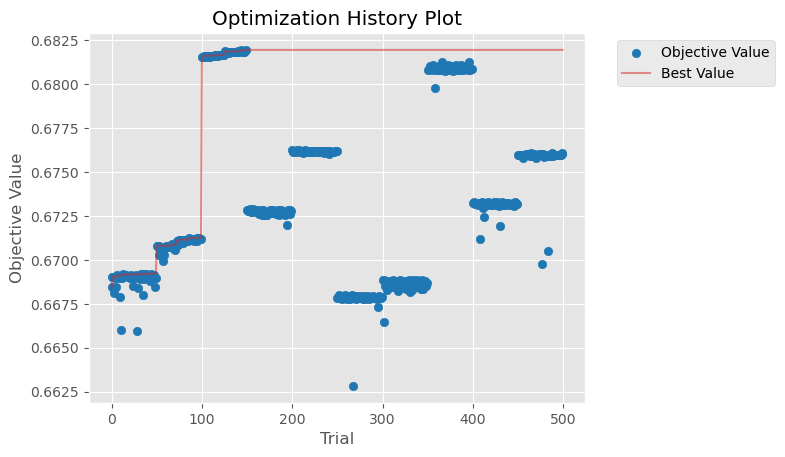

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.696147,0.027266
1,TP,165.300000,10.873515
2,TN,88.800000,5.865151
3,FP,24.600000,4.948625
4,FN,18.400000,5.059644
5,Accuracy,0.855272,0.031640
6,Precision,0.869794,0.030139
7,Sensitivity,0.899167,0.031153
8,Specificity,0.783740,0.035009
9,F1 score,0.884169,0.029549


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.701707,0.700515,0.676903,0.718249,0.663945,0.707662,0.702829,0.685792,0.702509,0.712557,0.697267,0.016758
1,TP,345.000000,333.000000,339.000000,336.000000,333.000000,344.000000,333.000000,340.000000,320.000000,329.000000,335.200000,7.420692
2,TN,170.000000,182.000000,167.000000,174.000000,170.000000,167.000000,182.000000,162.000000,184.000000,185.000000,174.300000,8.313978
3,FP,42.000000,48.000000,55.000000,52.000000,61.000000,51.000000,46.000000,58.000000,58.000000,46.000000,51.700000,6.236986
4,FN,38.000000,32.000000,34.000000,33.000000,31.000000,33.000000,34.000000,35.000000,33.000000,35.000000,33.800000,1.932184
5,Accuracy,0.865546,0.865546,0.850420,0.857143,0.845378,0.858824,0.865546,0.843697,0.847059,0.863866,0.856303,0.008937
6,Precision,0.891473,0.874016,0.860406,0.865979,0.845178,0.870886,0.878628,0.854271,0.846561,0.877333,0.866473,0.014918
7,Sensitivity,0.900783,0.912329,0.908847,0.910569,0.914835,0.912467,0.907357,0.906667,0.906516,0.903846,0.908422,0.004278
8,Specificity,0.801900,0.791300,0.752300,0.769900,0.735900,0.766100,0.798200,0.736400,0.760300,0.800900,0.771320,0.025643
9,F1 score,0.896104,0.892761,0.883963,0.887715,0.878628,0.891192,0.892761,0.879690,0.875513,0.890392,0.886872,0.007019


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
rf_5preds = pd.concat([chembl_id, rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
rf_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_rf0,y_pred_rf1,y_pred_rf2,y_pred_rf3,y_pred_rf4,y_pred_rf_ave,y_pred_rf_std
0,CHEMBL4084049,0,6.26,8.837534,8.719624,8.966145,8.831776,8.896641,8.418620,0.968222
1,CHEMBL2178343,1,5.96,5.878593,6.097581,5.952685,5.950197,5.901396,5.956742,0.069613
2,CHEMBL454672,2,6.80,6.447077,6.419462,6.404847,6.539621,6.554507,6.527586,0.134360
3,CHEMBL4299417,3,8.14,7.364052,7.362639,7.604408,7.729317,7.330781,7.588533,0.286369
4,CHEMBL3692580,4,5.24,5.632797,5.728714,5.685316,5.657134,5.777915,5.620313,0.176524
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL3775269,2966,7.40,6.972033,7.017793,6.963299,7.058152,7.116940,7.088036,0.148885
2967,CHEMBL3339019,2967,8.07,7.988166,7.811777,7.967202,7.998701,8.012441,7.974714,0.079440
2968,CHEMBL3771312,2968,6.52,6.292977,6.173414,6.232690,6.270167,6.259155,6.291400,0.108872
2969,CHEMBL3589701,2969,6.49,7.115708,7.219419,7.072490,7.097079,7.067160,7.010309,0.238112


In [38]:
mat_met_optimized_rf

,Metric,Value (average),Value (std)
0,R2,0.699620,0.032128
1,Accuracy,0.855941,0.020113
2,Precision,0.870435,0.024364
3,Sensitivity,0.901485,0.023598
4,Specificity,0.782290,0.041462
5,F1 score,0.885362,0.016877
6,F1 score (weighted),0.854994,0.020344
7,F1 score (macro),0.845237,0.021377
8,Balanced Accuracy,0.841885,0.022128
9,MCC,0.692580,0.042335


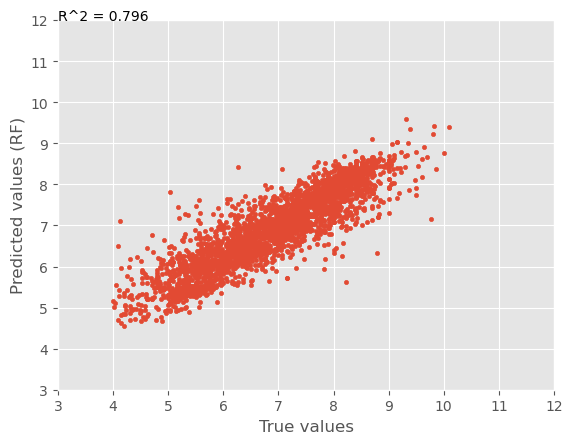

In [39]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (RF)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'])), (3, 12))
plt.show()

In [40]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_reg, X, Y, cv=10, scoring="r2")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="r2")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="r2")
print("RF baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model r2_score 0.6948 with a standard deviation of 0.0331
RF optimized model r2_score 0.6995 with a standard deviation of 0.0310


In [41]:
import joblib
joblib.dump(rf_reg, "OUTPUT/rf_reg.joblib")
#joblib.dump(optimized_rf, "OUTPUT/optimized_rf.joblib") # fitted to whole training set with last random_state selected
joblib.dump(optimizedCV_rf, "OUTPUT/optimizedCV_rf.joblib")

['OUTPUT/optimizedCV_rf.joblib']

## LGBMRegressor

In [42]:
%%time


r2_scores = np.empty(10)
TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_reg = lgbm.LGBMRegressor(
        objective="regression",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=8,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_reg.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="rmse",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_reg.predict(X_test) 
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met_lgbm = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    R2         0.695224     0.025102
1                    TP       162.000000     9.729680
2                    TN        88.000000     5.291503
3                    FP        25.400000     4.765618
4                    FN        21.700000     4.001389
5              Accuracy         0.841468     0.024605
6             Precision         0.863994     0.028421
7           Sensitivity         0.881358     0.025407
8           Specificity         0.776850     0.032157
9              F1 score         0.872453     0.024433
10  F1 score (weighted)         0.840940     0.024737
11     F1 score (macro)         0.830864     0.023540
12    Balanced Accuracy         0.829100     0.023812
13                  MCC         0.662469     0.046904
14                  NPV         0.802820     0.027822
15              ROC_AUC         0.829100     0.023812
CPU times: user 14.7 s, sys: 100 ms, total: 14.8 s
Wall time: 1.95 s


In [43]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [44]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        
    }
    
    
    
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
         # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [45]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="lgbmRegressor")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:32:02,220] A new study created in memory with name: lgbmRegressor
[I 2023-12-20 11:32:03,797] Trial 0 finished with value: 0.657906222195145 and parameters: {'n_estimators': 655, 'learning_rate': 0.16492323815512352, 'max_depth': 4, 'max_bin': 260, 'num_leaves': 213}. Best is trial 0 with value: 0.657906222195145.
[I 2023-12-20 11:32:05,847] Trial 1 finished with value: 0.6604765646714678 and parameters: {'n_estimators': 549, 'learning_rate': 0.10659748520191774, 'max_depth': 5, 'max_bin': 281, 'num_leaves': 198}. Best is trial 1 with value: 0.6604765646714678.
[I 2023-12-20 11:32:06,900] Trial 2 finished with value: 0.5544178391974761 and parameters: {'n_estimators': 161, 'learning_rate': 0.026833692786492377, 'max_depth': 4, 'max_bin': 286, 'num_leaves': 371}. Best is trial 1 with value: 0.6604765646714678.
[I 2023-12-20 11:32:08,941] Trial 3 finished with value: 0.6697559205622158 and parameters: {'n_estimators': 897, 'learning_rate': 0.1544478360939618, 'max_depth'

	Number of trials: 50.0
	Best value (r2_score): 0.6835
	Best params:
		n_estimators: 699
		learning_rate: 0.04012749765314866
		max_depth: 12
		max_bin: 282
		num_leaves: 371


In [46]:
optimized_lgbm_0 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_lgbm_0)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_0_cat = np.where((y_pred_lgbm_0>= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_lgbm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_lgbm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_lgbm_0_cat)


mat_met_lgbm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    R2    0.715728
1                    TP  343.000000
2                    TN  170.000000
3                    FP   42.000000
4                    FN   40.000000
5              Accuracy    0.862185
6             Precision    0.890909
7           Sensitivity    0.895561
8           Specificity    0.801900
9              F1 score    0.893229
10  F1 score (weighted)    0.862038
11     F1 score (macro)    0.849458
12    Balanced Accuracy    0.848724
13                  MCC    0.698939
14                  NPV    0.809500
15              ROC_AUC    0.848724


In [47]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:35:29,837] Trial 50 finished with value: 0.687274320115347 and parameters: {'n_estimators': 728, 'learning_rate': 0.04067600164839472, 'max_depth': 11, 'max_bin': 231, 'num_leaves': 302}. Best is trial 50 with value: 0.687274320115347.
[I 2023-12-20 11:35:34,582] Trial 51 finished with value: 0.6878036907117739 and parameters: {'n_estimators': 727, 'learning_rate': 0.042153255681300655, 'max_depth': 11, 'max_bin': 231, 'num_leaves': 258}. Best is trial 51 with value: 0.6878036907117739.
[I 2023-12-20 11:35:38,922] Trial 52 finished with value: 0.6866538052814001 and parameters: {'n_estimators': 671, 'learning_rate': 0.04322556501208784, 'max_depth': 10, 'max_bin': 229, 'num_leaves': 302}. Best is trial 51 with value: 0.6878036907117739.
[I 2023-12-20 11:35:42,606] Trial 53 finished with value: 0.6871011371940992 and parameters: {'n_estimators': 506, 'learning_rate': 0.05894539062411565, 'max_depth': 10, 'max_bin': 229, 'num_leaves': 307}. Best is trial 51 with value: 0

	Number of trials: 100.0
	Best value (r2_score): 0.6927
	Best params:
		n_estimators: 543
		learning_rate: 0.08167653493955698
		max_depth: 10
		max_bin: 219
		num_leaves: 285


In [48]:
optimized_lgbm_1 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_lgbm_1)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_1_cat = np.where((y_pred_lgbm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_lgbm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_lgbm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_lgbm_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    R2    0.715728    0.717255
1                    TP  343.000000  332.000000
2                    TN  170.000000  174.000000
3                    FP   42.000000   56.000000
4                    FN   40.000000   33.000000
5              Accuracy    0.862185    0.850420
6             Precision    0.890909    0.855670
7           Sensitivity    0.895561    0.909589
8           Specificity    0.801900    0.756500
9              F1 score    0.893229    0.881806
10  F1 score (weighted)    0.862038    0.848768
11     F1 score (macro)    0.849458    0.839072
12    Balanced Accuracy    0.848724    0.833055
13                  MCC    0.698939    0.681014
14                  NPV    0.809500    0.840600
15              ROC_AUC    0.848724    0.833055


In [49]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:38:17,291] Trial 100 finished with value: 0.6846247749829466 and parameters: {'n_estimators': 444, 'learning_rate': 0.07384881562637256, 'max_depth': 9, 'max_bin': 194, 'num_leaves': 568}. Best is trial 82 with value: 0.6927201522444425.
[I 2023-12-20 11:38:20,203] Trial 101 finished with value: 0.6903778909279967 and parameters: {'n_estimators': 541, 'learning_rate': 0.0860459890566046, 'max_depth': 11, 'max_bin': 239, 'num_leaves': 381}. Best is trial 82 with value: 0.6927201522444425.
[I 2023-12-20 11:38:23,230] Trial 102 finished with value: 0.6919691204688563 and parameters: {'n_estimators': 527, 'learning_rate': 0.08218383926063097, 'max_depth': 11, 'max_bin': 249, 'num_leaves': 382}. Best is trial 82 with value: 0.6927201522444425.
[I 2023-12-20 11:38:26,724] Trial 103 finished with value: 0.6887820518320004 and parameters: {'n_estimators': 619, 'learning_rate': 0.08313840895308452, 'max_depth': 11, 'max_bin': 249, 'num_leaves': 418}. Best is trial 82 with value

	Number of trials: 150.0
	Best value (r2_score): 0.6990
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [50]:
optimized_lgbm_2 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_lgbm_2)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_2_cat = np.where((y_pred_lgbm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_lgbm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_lgbm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_lgbm_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.715728    0.717255    0.694202
1                    TP  343.000000  332.000000  333.000000
2                    TN  170.000000  174.000000  172.000000
3                    FP   42.000000   56.000000   50.000000
4                    FN   40.000000   33.000000   40.000000
5              Accuracy    0.862185    0.850420    0.848739
6             Precision    0.890909    0.855670    0.869452
7           Sensitivity    0.895561    0.909589    0.892761
8           Specificity    0.801900    0.756500    0.774800
9              F1 score    0.893229    0.881806    0.880952
10  F1 score (weighted)    0.862038    0.848768    0.847997
11     F1 score (macro)    0.849458    0.839072    0.836790
12    Balanced Accuracy    0.848724    0.833055    0.833768
13                  MCC    0.698939    0.681014    0.674122
14                  NPV    0.809500    0.840600    0.811300
15              ROC_AUC    0.848724    0

In [51]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:41:03,978] Trial 150 finished with value: 0.663944518106398 and parameters: {'n_estimators': 526, 'learning_rate': 0.11155550034384552, 'max_depth': 12, 'max_bin': 251, 'num_leaves': 685}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:41:06,701] Trial 151 finished with value: 0.6646687650291163 and parameters: {'n_estimators': 606, 'learning_rate': 0.10268513738013528, 'max_depth': 12, 'max_bin': 260, 'num_leaves': 598}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:41:09,625] Trial 152 finished with value: 0.6696828855486764 and parameters: {'n_estimators': 592, 'learning_rate': 0.09494445381680433, 'max_depth': 12, 'max_bin': 259, 'num_leaves': 701}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:41:12,552] Trial 153 finished with value: 0.667758554401529 and parameters: {'n_estimators': 552, 'learning_rate': 0.09129835421869129, 'max_depth': 12, 'max_bin': 266, 'num_leaves': 663}. Best is trial 123 with v

	Number of trials: 200.0
	Best value (r2_score): 0.6990
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [52]:
optimized_lgbm_3 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_lgbm_3)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_3_cat = np.where((y_pred_lgbm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_lgbm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_lgbm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_lgbm_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.715728    0.717255    0.694202    0.738094
1                    TP  343.000000  332.000000  333.000000  332.000000
2                    TN  170.000000  174.000000  172.000000  185.000000
3                    FP   42.000000   56.000000   50.000000   41.000000
4                    FN   40.000000   33.000000   40.000000   37.000000
5              Accuracy    0.862185    0.850420    0.848739    0.868908
6             Precision    0.890909    0.855670    0.869452    0.890080
7           Sensitivity    0.895561    0.909589    0.892761    0.899729
8           Specificity    0.801900    0.756500    0.774800    0.818600
9              F1 score    0.893229    0.881806    0.880952    0.894879
10  F1 score (weighted)    0.862038    0.848768    0.847997    0.868676
11     F1 score (macro)    0.849458    0.839072    0.836790    0.860386
12    Balanced Accuracy    0.848724    0.833055    0.833768    0

In [53]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:43:30,971] Trial 200 finished with value: 0.691072073111395 and parameters: {'n_estimators': 564, 'learning_rate': 0.10144047923973257, 'max_depth': 12, 'max_bin': 261, 'num_leaves': 606}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:43:34,747] Trial 201 finished with value: 0.6890588875215512 and parameters: {'n_estimators': 645, 'learning_rate': 0.09154924041975339, 'max_depth': 12, 'max_bin': 262, 'num_leaves': 673}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:43:38,392] Trial 202 finished with value: 0.6911006016140896 and parameters: {'n_estimators': 633, 'learning_rate': 0.09419905538998007, 'max_depth': 12, 'max_bin': 256, 'num_leaves': 667}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:43:42,126] Trial 203 finished with value: 0.6897836491984068 and parameters: {'n_estimators': 619, 'learning_rate': 0.08653936381600637, 'max_depth': 12, 'max_bin': 267, 'num_leaves': 691}. Best is trial 123 with 

	Number of trials: 250.0
	Best value (r2_score): 0.6990
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [54]:
optimized_lgbm_4 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_lgbm_4)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_4_cat = np.where((y_pred_lgbm_4 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_lgbm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_lgbm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_lgbm_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.715728    0.717255    0.694202    0.738094   
1                    TP  343.000000  332.000000  333.000000  332.000000   
2                    TN  170.000000  174.000000  172.000000  185.000000   
3                    FP   42.000000   56.000000   50.000000   41.000000   
4                    FN   40.000000   33.000000   40.000000   37.000000   
5              Accuracy    0.862185    0.850420    0.848739    0.868908   
6             Precision    0.890909    0.855670    0.869452    0.890080   
7           Sensitivity    0.895561    0.909589    0.892761    0.899729   
8           Specificity    0.801900    0.756500    0.774800    0.818600   
9              F1 score    0.893229    0.881806    0.880952    0.894879   
10  F1 score (weighted)    0.862038    0.848768    0.847997    0.868676   
11     F1 score (macro)    0.849458    0.839072    0.836790    0.860386   
12    Balanced Accuracy  

In [55]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:46:23,491] Trial 250 finished with value: 0.6822268252339306 and parameters: {'n_estimators': 598, 'learning_rate': 0.078878118178478, 'max_depth': 12, 'max_bin': 267, 'num_leaves': 680}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:46:26,583] Trial 251 finished with value: 0.6809138456717088 and parameters: {'n_estimators': 618, 'learning_rate': 0.0841280068692746, 'max_depth': 12, 'max_bin': 256, 'num_leaves': 654}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:46:29,877] Trial 252 finished with value: 0.6829395628025832 and parameters: {'n_estimators': 671, 'learning_rate': 0.0919171046334233, 'max_depth': 12, 'max_bin': 259, 'num_leaves': 750}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:46:32,914] Trial 253 finished with value: 0.6821002405869397 and parameters: {'n_estimators': 547, 'learning_rate': 0.09581198068805412, 'max_depth': 12, 'max_bin': 176, 'num_leaves': 699}. Best is trial 123 with val

	Number of trials: 300.0
	Best value (r2_score): 0.6990
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [56]:
optimized_lgbm_5 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_lgbm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_5_cat = np.where((y_pred_lgbm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_lgbm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_lgbm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_lgbm_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.715728    0.717255    0.694202    0.738094   
1                    TP  343.000000  332.000000  333.000000  332.000000   
2                    TN  170.000000  174.000000  172.000000  185.000000   
3                    FP   42.000000   56.000000   50.000000   41.000000   
4                    FN   40.000000   33.000000   40.000000   37.000000   
5              Accuracy    0.862185    0.850420    0.848739    0.868908   
6             Precision    0.890909    0.855670    0.869452    0.890080   
7           Sensitivity    0.895561    0.909589    0.892761    0.899729   
8           Specificity    0.801900    0.756500    0.774800    0.818600   
9              F1 score    0.893229    0.881806    0.880952    0.894879   
10  F1 score (weighted)    0.862038    0.848768    0.847997    0.868676   
11     F1 score (macro)    0.849458    0.839072    0.836790    0.860386   
12    Balanced Accuracy  

In [57]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:49:20,879] Trial 300 finished with value: 0.6883296401023598 and parameters: {'n_estimators': 502, 'learning_rate': 0.08054682673102434, 'max_depth': 12, 'max_bin': 257, 'num_leaves': 650}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:49:24,676] Trial 301 finished with value: 0.6916068490943303 and parameters: {'n_estimators': 587, 'learning_rate': 0.0935064448046914, 'max_depth': 12, 'max_bin': 264, 'num_leaves': 613}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:49:28,231] Trial 302 finished with value: 0.6886740247520062 and parameters: {'n_estimators': 607, 'learning_rate': 0.10087273878678085, 'max_depth': 12, 'max_bin': 261, 'num_leaves': 679}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:49:30,544] Trial 303 finished with value: 0.6703305291309063 and parameters: {'n_estimators': 576, 'learning_rate': 0.08675880299396951, 'max_depth': 5, 'max_bin': 271, 'num_leaves': 662}. Best is trial 123 with v

	Number of trials: 350.0
	Best value (r2_score): 0.699013
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [58]:
optimized_lgbm_6 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_lgbm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_6_cat = np.where((y_pred_lgbm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_lgbm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_lgbm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_lgbm_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.715728    0.717255    0.694202    0.738094   
1                    TP  343.000000  332.000000  333.000000  332.000000   
2                    TN  170.000000  174.000000  172.000000  185.000000   
3                    FP   42.000000   56.000000   50.000000   41.000000   
4                    FN   40.000000   33.000000   40.000000   37.000000   
5              Accuracy    0.862185    0.850420    0.848739    0.868908   
6             Precision    0.890909    0.855670    0.869452    0.890080   
7           Sensitivity    0.895561    0.909589    0.892761    0.899729   
8           Specificity    0.801900    0.756500    0.774800    0.818600   
9              F1 score    0.893229    0.881806    0.880952    0.894879   
10  F1 score (weighted)    0.862038    0.848768    0.847997    0.868676   
11     F1 score (macro)    0.849458    0.839072    0.836790    0.860386   
12    Balanced Accuracy  

In [59]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:52:22,537] Trial 350 finished with value: 0.6929187288633326 and parameters: {'n_estimators': 708, 'learning_rate': 0.0897032325173672, 'max_depth': 12, 'max_bin': 260, 'num_leaves': 697}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:52:25,133] Trial 351 finished with value: 0.6902423176981625 and parameters: {'n_estimators': 589, 'learning_rate': 0.15122229354451677, 'max_depth': 11, 'max_bin': 264, 'num_leaves': 661}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:52:28,790] Trial 352 finished with value: 0.6898110095708481 and parameters: {'n_estimators': 625, 'learning_rate': 0.08233050086896285, 'max_depth': 12, 'max_bin': 253, 'num_leaves': 621}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:52:33,874] Trial 353 finished with value: 0.6914141020091783 and parameters: {'n_estimators': 651, 'learning_rate': 0.045958962699042885, 'max_depth': 12, 'max_bin': 276, 'num_leaves': 678}. Best is trial 123 with

	Number of trials: 400.0
	Best value (r2_score): 0.6990132
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [60]:
optimized_lgbm_7 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_lgbm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_7_cat = np.where((y_pred_lgbm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_lgbm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_lgbm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_lgbm_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.715728    0.717255    0.694202    0.738094   
1                    TP  343.000000  332.000000  333.000000  332.000000   
2                    TN  170.000000  174.000000  172.000000  185.000000   
3                    FP   42.000000   56.000000   50.000000   41.000000   
4                    FN   40.000000   33.000000   40.000000   37.000000   
5              Accuracy    0.862185    0.850420    0.848739    0.868908   
6             Precision    0.890909    0.855670    0.869452    0.890080   
7           Sensitivity    0.895561    0.909589    0.892761    0.899729   
8           Specificity    0.801900    0.756500    0.774800    0.818600   
9              F1 score    0.893229    0.881806    0.880952    0.894879   
10  F1 score (weighted)    0.862038    0.848768    0.847997    0.868676   
11     F1 score (macro)    0.849458    0.839072    0.836790    0.860386   
12    Balanced Accuracy  

In [61]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:55:28,075] Trial 400 finished with value: 0.6829870475815489 and parameters: {'n_estimators': 560, 'learning_rate': 0.12741545816453353, 'max_depth': 12, 'max_bin': 267, 'num_leaves': 644}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:55:31,141] Trial 401 finished with value: 0.6773965521943243 and parameters: {'n_estimators': 598, 'learning_rate': 0.09888971064044327, 'max_depth': 11, 'max_bin': 261, 'num_leaves': 661}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:55:34,419] Trial 402 finished with value: 0.6770899674214316 and parameters: {'n_estimators': 620, 'learning_rate': 0.08208045817158592, 'max_depth': 12, 'max_bin': 250, 'num_leaves': 623}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:55:37,829] Trial 403 finished with value: 0.67990838423781 and parameters: {'n_estimators': 574, 'learning_rate': 0.0876506339883867, 'max_depth': 12, 'max_bin': 258, 'num_leaves': 698}. Best is trial 123 with va

	Number of trials: 450.0
	Best value (r2_score): 0.69901317
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [62]:
optimized_lgbm_8 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_lgbm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_8_cat = np.where((y_pred_lgbm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_lgbm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_lgbm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_lgbm_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.715728    0.717255    0.694202    0.738094   
1                    TP  343.000000  332.000000  333.000000  332.000000   
2                    TN  170.000000  174.000000  172.000000  185.000000   
3                    FP   42.000000   56.000000   50.000000   41.000000   
4                    FN   40.000000   33.000000   40.000000   37.000000   
5              Accuracy    0.862185    0.850420    0.848739    0.868908   
6             Precision    0.890909    0.855670    0.869452    0.890080   
7           Sensitivity    0.895561    0.909589    0.892761    0.899729   
8           Specificity    0.801900    0.756500    0.774800    0.818600   
9              F1 score    0.893229    0.881806    0.880952    0.894879   
10  F1 score (weighted)    0.862038    0.848768    0.847997    0.868676   
11     F1 score (macro)    0.849458    0.839072    0.836790    0.860386   
12    Balanced Accuracy  

In [63]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:58:28,469] Trial 450 finished with value: 0.6863229436858493 and parameters: {'n_estimators': 660, 'learning_rate': 0.0924603637111206, 'max_depth': 12, 'max_bin': 264, 'num_leaves': 719}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:58:31,476] Trial 451 finished with value: 0.6829481843220995 and parameters: {'n_estimators': 584, 'learning_rate': 0.09900271172022318, 'max_depth': 11, 'max_bin': 258, 'num_leaves': 675}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:58:33,936] Trial 452 finished with value: 0.6817946188386657 and parameters: {'n_estimators': 563, 'learning_rate': 0.13881517633965998, 'max_depth': 12, 'max_bin': 300, 'num_leaves': 629}. Best is trial 123 with value: 0.6990131690414316.
[I 2023-12-20 11:58:37,440] Trial 453 finished with value: 0.6863402917246907 and parameters: {'n_estimators': 613, 'learning_rate': 0.08391185626610925, 'max_depth': 12, 'max_bin': 253, 'num_leaves': 439}. Best is trial 123 with 

	Number of trials: 500.0
	Best value (r2_score): 0.699013169
	Best params:
		n_estimators: 578
		learning_rate: 0.09274509958766028
		max_depth: 12
		max_bin: 256
		num_leaves: 719


In [64]:
optimized_lgbm_9 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_lgbm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_9_cat = np.where((y_pred_lgbm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_lgbm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_lgbm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_lgbm_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.715728    0.717255    0.694202    0.738094   
1                    TP  343.000000  332.000000  333.000000  332.000000   
2                    TN  170.000000  174.000000  172.000000  185.000000   
3                    FP   42.000000   56.000000   50.000000   41.000000   
4                    FN   40.000000   33.000000   40.000000   37.000000   
5              Accuracy    0.862185    0.850420    0.848739    0.868908   
6             Precision    0.890909    0.855670    0.869452    0.890080   
7           Sensitivity    0.895561    0.909589    0.892761    0.899729   
8           Specificity    0.801900    0.756500    0.774800    0.818600   
9              F1 score    0.893229    0.881806    0.880952    0.894879   
10  F1 score (weighted)    0.862038    0.848768    0.847997    0.868676   
11     F1 score (macro)    0.849458    0.839072    0.836790    0.860386   
12    Balanced Accuracy  

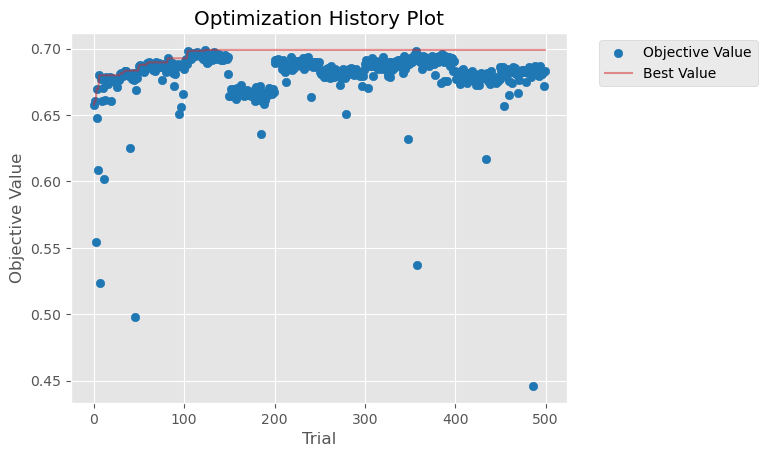

In [65]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

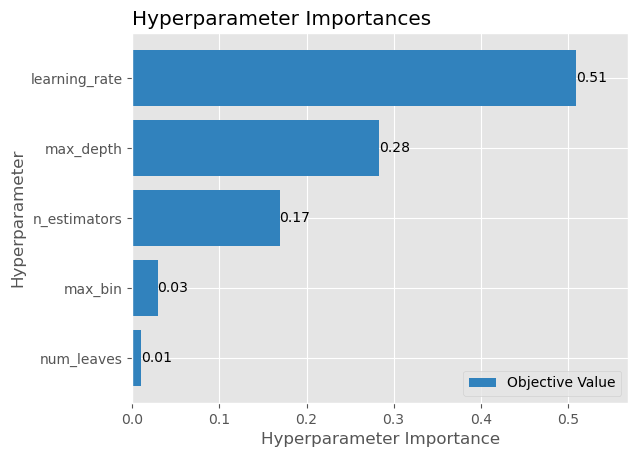

In [66]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [67]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    R2         0.708027     0.027724
1                    TP       162.900000    10.407796
2                    TN        88.900000     6.773314
3                    FP        24.500000     3.064129
4                    FN        20.800000     3.994441
5              Accuracy         0.847527     0.021114
6             Precision         0.868773     0.019823
7           Sensitivity         0.886087     0.025478
8           Specificity         0.783740     0.024688
9              F1 score         0.877282     0.021327
10  F1 score (weighted)         0.846994     0.020969
11     F1 score (macro)         0.837162     0.020238
12    Balanced Accuracy         0.834914     0.019525
13                  MCC         0.674857     0.040769
14                  NPV         0.811170     0.027923
15              ROC_AUC         0.834914     0.019525


In [68]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.715728,0.717255,0.694202,0.738094,0.681368,0.706702,0.694797,0.684628,0.724183,0.724018,0.708098,0.018830
1,TP,343.000000,332.000000,333.000000,332.000000,333.000000,338.000000,327.000000,323.000000,316.000000,335.000000,331.200000,7.627436
2,TN,170.000000,174.000000,172.000000,185.000000,169.000000,178.000000,173.000000,168.000000,185.000000,184.000000,175.800000,6.729702
3,FP,42.000000,56.000000,50.000000,41.000000,62.000000,40.000000,55.000000,52.000000,57.000000,47.000000,50.200000,7.539525
4,FN,40.000000,33.000000,40.000000,37.000000,31.000000,39.000000,40.000000,52.000000,37.000000,29.000000,37.800000,6.373556
5,Accuracy,0.862185,0.850420,0.848739,0.868908,0.843697,0.867227,0.840336,0.825210,0.842017,0.872269,0.852101,0.015157
6,Precision,0.890909,0.855670,0.869452,0.890080,0.843038,0.894180,0.856021,0.861333,0.847185,0.876963,0.868483,0.018780
7,Sensitivity,0.895561,0.909589,0.892761,0.899729,0.914835,0.896552,0.891008,0.861333,0.895184,0.920330,0.897688,0.016176
8,Specificity,0.801900,0.756500,0.774800,0.818600,0.731600,0.816500,0.758800,0.763600,0.764500,0.796500,0.778330,0.028726
9,F1 score,0.893229,0.881806,0.880952,0.894879,0.877470,0.895364,0.873164,0.861333,0.870523,0.898123,0.882685,0.012402


In [69]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
lgbm_5preds = pd.concat([chembl_id, lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
lgbm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_lgbm0,y_pred_lgbm1,y_pred_lgbm2,y_pred_lgbm3,y_pred_lgbm4,y_pred_lgbm_ave,y_pred_lgbm_std
0,CHEMBL4084049,0,6.26,8.878516,8.937248,9.085690,8.857421,9.108667,8.521257,1.015760
1,CHEMBL2178343,1,5.96,6.114580,6.157364,5.939508,6.246302,6.325022,6.123796,0.139942
2,CHEMBL454672,2,6.80,6.905282,6.537709,6.838597,6.742520,6.731499,6.759268,0.115045
3,CHEMBL4299417,3,8.14,7.512262,7.470262,7.548025,7.595083,7.436492,7.617021,0.239392
4,CHEMBL3692580,4,5.24,5.677999,5.905695,5.745454,5.773960,5.884241,5.704558,0.222018
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL3775269,2966,7.40,6.966037,7.028249,6.599467,7.110020,7.099422,7.033866,0.237166
2967,CHEMBL3339019,2967,8.07,8.090380,7.919378,8.125828,7.922273,8.077443,8.034217,0.082072
2968,CHEMBL3771312,2968,6.52,6.400063,6.133403,6.105581,6.509356,5.929801,6.266367,0.222881
2969,CHEMBL3589701,2969,6.49,7.110973,7.029569,7.064424,7.360439,6.844358,6.983294,0.267677


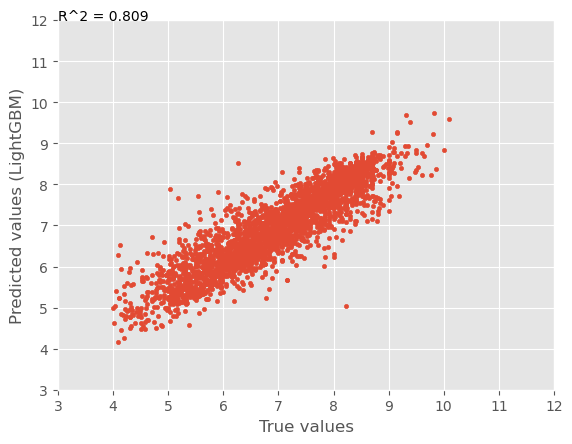

In [70]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'])), (3, 12))
plt.show()

In [71]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_reg, X, Y, cv=10, scoring="r2")
#r2_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="r2")
r2_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="r2", fit_params=fit_params)
print("LightGBM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)r2_score %0.4f with a standard deviation of %0.4f" % (r2_cv_lgbm_opt_testSet.mean(), r2_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(r2_cv_lgbm_opt), np.std(r2_cv_lgbm_opt, ddof=1)))

LightGBM baseline model r2_score 0.6875 with a standard deviation of 0.0260
LightGBM optimized model r2_score 0.6995 with a standard deviation of 0.0278


In [72]:
joblib.dump(lgbm_reg, "OUTPUT/lgbm_reg.joblib")
#joblib.dump(optimized_lgbm, "OUTPUT/optimized_lgbm.joblib")
joblib.dump(optimizedCV_lgbm, "OUTPUT/optimizedCV_lgbm.joblib") 
#loaded_rf = joblib.load("OUTPUT/optimized_rf.joblib")

['OUTPUT/optimizedCV_lgbm.joblib']

## XGBoost

In [73]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_reg.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores),np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.673113     0.016691
1                    TP       164.500000     8.592633
2                    TN        86.400000     4.325634
3                    FP        27.000000     4.714045
4                    FN        19.200000     4.049691
5              Accuracy         0.844502     0.023055
6             Precision         0.858615     0.027174
7           Sensitivity         0.895286     0.022657
8           Specificity         0.763010     0.028324
9              F1 score         0.876393     0.021587
10  F1 score (weighted)         0.843407     0.023202
11     F1 score (macro)         0.832953     0.022281
12    Balanced Accuracy         0.829141     0.021464
13                  MCC         0.667786     0.044512
14                  NPV         0.818870     0.034463
15              ROC_AUC         0.829141     0.021464
CPU times: user 44min 52s, sys: 1.3 s, total: 44min 54s
Wall time: 1min 35s


In [74]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
            
    return np.mean(cv_scores)

In [75]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [76]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBRegressor")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 12:03:50,281] A new study created in memory with name: XGBRegressor
[I 2023-12-20 12:04:02,362] Trial 0 finished with value: 0.3844853360150289 and parameters: {'n_estimators': 606, 'eta': 0.004933388081264989, 'max_depth': 12, 'alpha': 0.47250000000000003, 'lambda': 31.848924799307763, 'max_bin': 268}. Best is trial 0 with value: 0.3844853360150289.
[I 2023-12-20 12:04:15,925] Trial 1 finished with value: 0.667978127895575 and parameters: {'n_estimators': 466, 'eta': 0.015475368338753353, 'max_depth': 11, 'alpha': 0.0238, 'lambda': 10.317526140220128, 'max_bin': 391}. Best is trial 1 with value: 0.667978127895575.
[I 2023-12-20 12:04:25,745] Trial 2 finished with value: 0.6812226496276657 and parameters: {'n_estimators': 697, 'eta': 0.08036768841580752, 'max_depth': 9, 'alpha': 0.9136000000000001, 'lambda': 14.837415534196865, 'max_bin': 434}. Best is trial 2 with value: 0.6812226496276657.
[I 2023-12-20 12:04:38,451] Trial 3 finished with value: 0.6813655894817886 and p

	Number of trials: 50.0
	Best value (r2_score): 0.6910
	Best params:
		n_estimators: 871
		eta: 0.043660304597448726
		max_depth: 8
		alpha: 0.6636000000000001
		lambda: 31.66114386215811
		max_bin: 435


In [77]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

    # r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_xgb_0)
y_pred_xgb_0_cat = np.where((y_pred_xgb_0 >= 6.6), 1, 0)
    #calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_xgb_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_xgb_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_xgb_0_cat)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    R2    0.733450
1                    TP  349.000000
2                    TN  168.000000
3                    FP   44.000000
4                    FN   34.000000
5              Accuracy    0.868908
6             Precision    0.888041
7           Sensitivity    0.911227
8           Specificity    0.792500
9              F1 score    0.899485
10  F1 score (weighted)    0.868169
11     F1 score (macro)    0.855539
12    Balanced Accuracy    0.851840
13                  MCC    0.711657
14                  NPV    0.831700
15              ROC_AUC    0.851840


In [78]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 12:12:43,683] Trial 50 finished with value: 0.6909616445158642 and parameters: {'n_estimators': 866, 'eta': 0.08040596090614452, 'max_depth': 9, 'alpha': 0.5263, 'lambda': 26.767296873056623, 'max_bin': 401}. Best is trial 18 with value: 0.6909837714801064.
[I 2023-12-20 12:12:55,900] Trial 51 finished with value: 0.6904513011882236 and parameters: {'n_estimators': 857, 'eta': 0.07915783476240157, 'max_depth': 9, 'alpha': 0.5319, 'lambda': 23.86750263752462, 'max_bin': 437}. Best is trial 18 with value: 0.6909837714801064.
[I 2023-12-20 12:13:09,304] Trial 52 finished with value: 0.6896130897614058 and parameters: {'n_estimators': 862, 'eta': 0.0757211799006327, 'max_depth': 9, 'alpha': 0.5214, 'lambda': 26.568913383649775, 'max_bin': 464}. Best is trial 18 with value: 0.6909837714801064.
[I 2023-12-20 12:13:20,895] Trial 53 finished with value: 0.6891827481941876 and parameters: {'n_estimators': 809, 'eta': 0.07487033479174779, 'max_depth': 9, 'alpha': 0.5268, 'lambda': 

	Number of trials: 100.0
	Best value (r2_score): 0.6960
	Best params:
		n_estimators: 655
		eta: 0.0506166923482371
		max_depth: 10
		alpha: 0.9786
		lambda: 30.234544740700578
		max_bin: 442


In [79]:
optimized_xgb_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_xgb_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_1_cat = np.where((y_pred_xgb_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_xgb_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_xgb_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_xgb_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    R2    0.733450    0.709249
1                    TP  349.000000  326.000000
2                    TN  168.000000  175.000000
3                    FP   44.000000   55.000000
4                    FN   34.000000   39.000000
5              Accuracy    0.868908    0.842017
6             Precision    0.888041    0.855643
7           Sensitivity    0.911227    0.893151
8           Specificity    0.792500    0.760900
9              F1 score    0.899485    0.873995
10  F1 score (weighted)    0.868169    0.840864
11     F1 score (macro)    0.855539    0.831141
12    Balanced Accuracy    0.851840    0.827010
13                  MCC    0.711657    0.663639
14                  NPV    0.831700    0.817800
15              ROC_AUC    0.851840    0.827010


In [80]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 12:25:38,198] Trial 100 finished with value: 0.7044423270777538 and parameters: {'n_estimators': 729, 'eta': 0.05377098800571908, 'max_depth': 9, 'alpha': 0.7555000000000001, 'lambda': 35.21390932887055, 'max_bin': 455}. Best is trial 100 with value: 0.7044423270777538.
[I 2023-12-20 12:25:53,792] Trial 101 finished with value: 0.7037075612093825 and parameters: {'n_estimators': 717, 'eta': 0.05415057247927819, 'max_depth': 9, 'alpha': 0.7416, 'lambda': 33.58077749893111, 'max_bin': 431}. Best is trial 100 with value: 0.7044423270777538.
[I 2023-12-20 12:26:09,912] Trial 102 finished with value: 0.705214520901297 and parameters: {'n_estimators': 722, 'eta': 0.054399433036234734, 'max_depth': 9, 'alpha': 0.7556, 'lambda': 36.23218912466738, 'max_bin': 441}. Best is trial 102 with value: 0.705214520901297.
[I 2023-12-20 12:26:26,057] Trial 103 finished with value: 0.7070320620717057 and parameters: {'n_estimators': 743, 'eta': 0.053554575310967655, 'max_depth': 9, 'alpha': 

	Number of trials: 150.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [81]:
optimized_xgb_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_xgb_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_2_cat = np.where((y_pred_xgb_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_xgb_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_xgb_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_xgb_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.733450    0.709249    0.685721
1                    TP  349.000000  326.000000  335.000000
2                    TN  168.000000  175.000000  172.000000
3                    FP   44.000000   55.000000   50.000000
4                    FN   34.000000   39.000000   38.000000
5              Accuracy    0.868908    0.842017    0.852101
6             Precision    0.888041    0.855643    0.870130
7           Sensitivity    0.911227    0.893151    0.898123
8           Specificity    0.792500    0.760900    0.774800
9              F1 score    0.899485    0.873995    0.883905
10  F1 score (weighted)    0.868169    0.840864    0.851217
11     F1 score (macro)    0.855539    0.831141    0.840101
12    Balanced Accuracy    0.851840    0.827010    0.836449
13                  MCC    0.711657    0.663639    0.680989
14                  NPV    0.831700    0.817800    0.819000
15              ROC_AUC    0.851840    0

In [82]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 12:38:08,453] Trial 150 finished with value: 0.6788500057852017 and parameters: {'n_estimators': 801, 'eta': 0.05821854394354962, 'max_depth': 7, 'alpha': 0.8753000000000001, 'lambda': 38.14801208019432, 'max_bin': 414}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 12:38:22,394] Trial 151 finished with value: 0.6815103438334329 and parameters: {'n_estimators': 766, 'eta': 0.05667108633970791, 'max_depth': 8, 'alpha': 0.8646, 'lambda': 39.06942703303547, 'max_bin': 395}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 12:38:34,099] Trial 152 finished with value: 0.6769258075107494 and parameters: {'n_estimators': 775, 'eta': 0.062068980747741184, 'max_depth': 8, 'alpha': 0.9144, 'lambda': 38.446517979516166, 'max_bin': 409}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 12:38:48,140] Trial 153 finished with value: 0.6776949917340512 and parameters: {'n_estimators': 758, 'eta': 0.05184536112013584, 'max_depth': 8, 'alpha'

	Number of trials: 200.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [83]:
optimized_xgb_3 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_xgb_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_3_cat = np.where((y_pred_xgb_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_xgb_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_xgb_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_xgb_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.733450    0.709249    0.685721    0.744080
1                    TP  349.000000  326.000000  335.000000  333.000000
2                    TN  168.000000  175.000000  172.000000  183.000000
3                    FP   44.000000   55.000000   50.000000   43.000000
4                    FN   34.000000   39.000000   38.000000   36.000000
5              Accuracy    0.868908    0.842017    0.852101    0.867227
6             Precision    0.888041    0.855643    0.870130    0.885638
7           Sensitivity    0.911227    0.893151    0.898123    0.902439
8           Specificity    0.792500    0.760900    0.774800    0.809700
9              F1 score    0.899485    0.873995    0.883905    0.893960
10  F1 score (weighted)    0.868169    0.840864    0.851217    0.866806
11     F1 score (macro)    0.855539    0.831141    0.840101    0.858216
12    Balanced Accuracy    0.851840    0.827010    0.836449    0

In [84]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 12:48:35,483] Trial 200 finished with value: 0.6959443378119495 and parameters: {'n_estimators': 831, 'eta': 0.058515432922029896, 'max_depth': 7, 'alpha': 0.7883, 'lambda': 36.95105983377507, 'max_bin': 400}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 12:48:49,386] Trial 201 finished with value: 0.6978809652552751 and parameters: {'n_estimators': 795, 'eta': 0.06454431660049155, 'max_depth': 8, 'alpha': 0.8229000000000001, 'lambda': 37.84724149204441, 'max_bin': 417}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 12:49:03,249] Trial 202 finished with value: 0.7028297548028009 and parameters: {'n_estimators': 774, 'eta': 0.06821887443761854, 'max_depth': 8, 'alpha': 0.8458, 'lambda': 38.891284864876575, 'max_bin': 422}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 12:49:17,094] Trial 203 finished with value: 0.6997189959026023 and parameters: {'n_estimators': 811, 'eta': 0.06307015469789969, 'max_depth': 8, 'alpha'

	Number of trials: 250.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [85]:
optimized_xgb_4 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_xgb_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_4_cat = np.where((y_pred_xgb_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_xgb_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_xgb_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_xgb_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.733450    0.709249    0.685721    0.744080   
1                    TP  349.000000  326.000000  335.000000  333.000000   
2                    TN  168.000000  175.000000  172.000000  183.000000   
3                    FP   44.000000   55.000000   50.000000   43.000000   
4                    FN   34.000000   39.000000   38.000000   36.000000   
5              Accuracy    0.868908    0.842017    0.852101    0.867227   
6             Precision    0.888041    0.855643    0.870130    0.885638   
7           Sensitivity    0.911227    0.893151    0.898123    0.902439   
8           Specificity    0.792500    0.760900    0.774800    0.809700   
9              F1 score    0.899485    0.873995    0.883905    0.893960   
10  F1 score (weighted)    0.868169    0.840864    0.851217    0.866806   
11     F1 score (macro)    0.855539    0.831141    0.840101    0.858216   
12    Balanced Accuracy  

In [86]:
len(y_pred_xgb_4_cat)

595

In [87]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 13:00:42,476] Trial 250 finished with value: 0.689080597736644 and parameters: {'n_estimators': 739, 'eta': 0.05412068604544054, 'max_depth': 8, 'alpha': 0.8751, 'lambda': 4.714440963790171, 'max_bin': 420}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:00:56,287] Trial 251 finished with value: 0.6909412731462352 and parameters: {'n_estimators': 832, 'eta': 0.061814227287679144, 'max_depth': 8, 'alpha': 0.736, 'lambda': 37.308079686829885, 'max_bin': 405}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:01:09,005] Trial 252 finished with value: 0.688961700163102 and parameters: {'n_estimators': 758, 'eta': 0.06478168248042654, 'max_depth': 8, 'alpha': 0.8005, 'lambda': 38.14631683536538, 'max_bin': 379}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:01:23,896] Trial 253 finished with value: 0.6887055257014367 and parameters: {'n_estimators': 809, 'eta': 0.057025982479271695, 'max_depth': 9, 'alpha': 0.766, 'lamb

	Number of trials: 300.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [88]:
optimized_xgb_5 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_xgb_5)
# now convert the resuls to binary with cutoff 6.5

y_pred_xgb_5_cat = np.where((y_pred_xgb_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_xgb_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_xgb_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_xgb_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.733450    0.709249    0.685721    0.744080   
1                    TP  349.000000  326.000000  335.000000  333.000000   
2                    TN  168.000000  175.000000  172.000000  183.000000   
3                    FP   44.000000   55.000000   50.000000   43.000000   
4                    FN   34.000000   39.000000   38.000000   36.000000   
5              Accuracy    0.868908    0.842017    0.852101    0.867227   
6             Precision    0.888041    0.855643    0.870130    0.885638   
7           Sensitivity    0.911227    0.893151    0.898123    0.902439   
8           Specificity    0.792500    0.760900    0.774800    0.809700   
9              F1 score    0.899485    0.873995    0.883905    0.893960   
10  F1 score (weighted)    0.868169    0.840864    0.851217    0.866806   
11     F1 score (macro)    0.855539    0.831141    0.840101    0.858216   
12    Balanced Accuracy  

In [89]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 13:11:56,681] Trial 300 finished with value: 0.6913896774027146 and parameters: {'n_estimators': 872, 'eta': 0.06364882036096932, 'max_depth': 8, 'alpha': 0.7676000000000001, 'lambda': 39.38883542930747, 'max_bin': 433}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:12:09,607] Trial 301 finished with value: 0.685607258503265 and parameters: {'n_estimators': 765, 'eta': 0.05805191248057508, 'max_depth': 8, 'alpha': 0.7831, 'lambda': 29.567578371530114, 'max_bin': 424}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:12:25,434] Trial 302 finished with value: 0.6889583570629182 and parameters: {'n_estimators': 793, 'eta': 0.0520834576101595, 'max_depth': 9, 'alpha': 0.8789, 'lambda': 33.709423382905086, 'max_bin': 400}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:12:37,691] Trial 303 finished with value: 0.6891684731976995 and parameters: {'n_estimators': 746, 'eta': 0.06691233693383554, 'max_depth': 8, 'alpha': 

	Number of trials: 350.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [90]:
optimized_xgb_6 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_xgb_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_6_cat = np.where((y_pred_xgb_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_xgb_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_xgb_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_xgb_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.733450    0.709249    0.685721    0.744080   
1                    TP  349.000000  326.000000  335.000000  333.000000   
2                    TN  168.000000  175.000000  172.000000  183.000000   
3                    FP   44.000000   55.000000   50.000000   43.000000   
4                    FN   34.000000   39.000000   38.000000   36.000000   
5              Accuracy    0.868908    0.842017    0.852101    0.867227   
6             Precision    0.888041    0.855643    0.870130    0.885638   
7           Sensitivity    0.911227    0.893151    0.898123    0.902439   
8           Specificity    0.792500    0.760900    0.774800    0.809700   
9              F1 score    0.899485    0.873995    0.883905    0.893960   
10  F1 score (weighted)    0.868169    0.840864    0.851217    0.866806   
11     F1 score (macro)    0.855539    0.831141    0.840101    0.858216   
12    Balanced Accuracy  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 13:23:37,960] Trial 350 finished with value: 0.6934676707667495 and parameters: {'n_estimators': 849, 'eta': 0.04943098334358285, 'max_depth': 8, 'alpha': 0.8497, 'lambda': 38.3738657129233, 'max_bin': 426}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:23:53,379] Trial 351 finished with value: 0.6950348320086982 and parameters: {'n_estimators': 774, 'eta': 0.0552309154010373, 'max_depth': 8, 'alpha': 0.8246, 'lambda': 39.40626459929836, 'max_bin': 409}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:24:03,940] Trial 352 finished with value: 0.6933655612378089 and parameters: {'n_estimators': 748, 'eta': 0.078878523651149, 'max_depth': 8, 'alpha': 0.7523000000000001, 'lambda': 25.08362173065336, 'max_bin': 447}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:24:08,845] Trial 353 finished with value: 0.687024509916516 and parameters: {'n_estimators': 247, 'eta': 0.09463411017445233, 'max_depth': 8, 'alpha': 0.427

	Number of trials: 400.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [92]:
optimized_xgb_7 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_xgb_7)
# now convert the resuls to binary with cutoff 6.7
y_pred_xgb_7_cat = np.where((y_pred_xgb_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_xgb_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_xgb_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_xgb_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.733450    0.709249    0.685721    0.744080   
1                    TP  349.000000  326.000000  335.000000  333.000000   
2                    TN  168.000000  175.000000  172.000000  183.000000   
3                    FP   44.000000   55.000000   50.000000   43.000000   
4                    FN   34.000000   39.000000   38.000000   36.000000   
5              Accuracy    0.868908    0.842017    0.852101    0.867227   
6             Precision    0.888041    0.855643    0.870130    0.885638   
7           Sensitivity    0.911227    0.893151    0.898123    0.902439   
8           Specificity    0.792500    0.760900    0.774800    0.809700   
9              F1 score    0.899485    0.873995    0.883905    0.893960   
10  F1 score (weighted)    0.868169    0.840864    0.851217    0.866806   
11     F1 score (macro)    0.855539    0.831141    0.840101    0.858216   
12    Balanced Accuracy  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 13:35:32,342] Trial 400 finished with value: 0.6916356267882969 and parameters: {'n_estimators': 806, 'eta': 0.0564468033471987, 'max_depth': 8, 'alpha': 0.7568, 'lambda': 26.341831769324212, 'max_bin': 412}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:35:51,208] Trial 401 finished with value: 0.6610708532777757 and parameters: {'n_estimators': 770, 'eta': 0.010319586747103926, 'max_depth': 9, 'alpha': 0.8657, 'lambda': 21.89501032752604, 'max_bin': 417}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:36:03,247] Trial 402 finished with value: 0.6867060913390506 and parameters: {'n_estimators': 893, 'eta': 0.07088505445113691, 'max_depth': 8, 'alpha': 0.7364, 'lambda': 36.60892019223973, 'max_bin': 404}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:36:17,809] Trial 403 finished with value: 0.6877362569347538 and parameters: {'n_estimators': 792, 'eta': 0.058073196276801964, 'max_depth': 8, 'alpha': 0.81300000

	Number of trials: 450.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [94]:
optimized_xgb_8 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_xgb_8)
# now convert the resuls to binary with cutoff 6.8
y_pred_xgb_8_cat = np.where((y_pred_xgb_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_xgb_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_xgb_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_xgb_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.733450    0.709249    0.685721    0.744080   
1                    TP  349.000000  326.000000  335.000000  333.000000   
2                    TN  168.000000  175.000000  172.000000  183.000000   
3                    FP   44.000000   55.000000   50.000000   43.000000   
4                    FN   34.000000   39.000000   38.000000   36.000000   
5              Accuracy    0.868908    0.842017    0.852101    0.867227   
6             Precision    0.888041    0.855643    0.870130    0.885638   
7           Sensitivity    0.911227    0.893151    0.898123    0.902439   
8           Specificity    0.792500    0.760900    0.774800    0.809700   
9              F1 score    0.899485    0.873995    0.883905    0.893960   
10  F1 score (weighted)    0.868169    0.840864    0.851217    0.866806   
11     F1 score (macro)    0.855539    0.831141    0.840101    0.858216   
12    Balanced Accuracy  

In [95]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 13:46:47,004] Trial 450 finished with value: 0.6903393161430701 and parameters: {'n_estimators': 786, 'eta': 0.08116069110803548, 'max_depth': 9, 'alpha': 0.7076, 'lambda': 37.06469013644204, 'max_bin': 382}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:46:59,053] Trial 451 finished with value: 0.6921006733079308 and parameters: {'n_estimators': 769, 'eta': 0.06195644635004216, 'max_depth': 8, 'alpha': 0.6806, 'lambda': 23.40644623807046, 'max_bin': 472}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:47:14,467] Trial 452 finished with value: 0.6920817015044461 and parameters: {'n_estimators': 832, 'eta': 0.05452104580570812, 'max_depth': 8, 'alpha': 0.8195, 'lambda': 25.68015429339902, 'max_bin': 413}. Best is trial 107 with value: 0.7074441570677151.
[I 2023-12-20 13:47:30,377] Trial 453 finished with value: 0.693210262707719 and parameters: {'n_estimators': 804, 'eta': 0.049361575887303555, 'max_depth': 8, 'alpha': 0.7804, 'lam

	Number of trials: 500.0
	Best value (r2_score): 0.7074
	Best params:
		n_estimators: 749
		eta: 0.054845717051706634
		max_depth: 8
		alpha: 0.7489
		lambda: 36.305982687842885
		max_bin: 416


In [96]:
optimized_xgb_9 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_xgb_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_9_cat = np.where((y_pred_xgb_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_xgb_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_xgb_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_xgb_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.733450    0.709249    0.685721    0.744080   
1                    TP  349.000000  326.000000  335.000000  333.000000   
2                    TN  168.000000  175.000000  172.000000  183.000000   
3                    FP   44.000000   55.000000   50.000000   43.000000   
4                    FN   34.000000   39.000000   38.000000   36.000000   
5              Accuracy    0.868908    0.842017    0.852101    0.867227   
6             Precision    0.888041    0.855643    0.870130    0.885638   
7           Sensitivity    0.911227    0.893151    0.898123    0.902439   
8           Specificity    0.792500    0.760900    0.774800    0.809700   
9              F1 score    0.899485    0.873995    0.883905    0.893960   
10  F1 score (weighted)    0.868169    0.840864    0.851217    0.866806   
11     F1 score (macro)    0.855539    0.831141    0.840101    0.858216   
12    Balanced Accuracy  

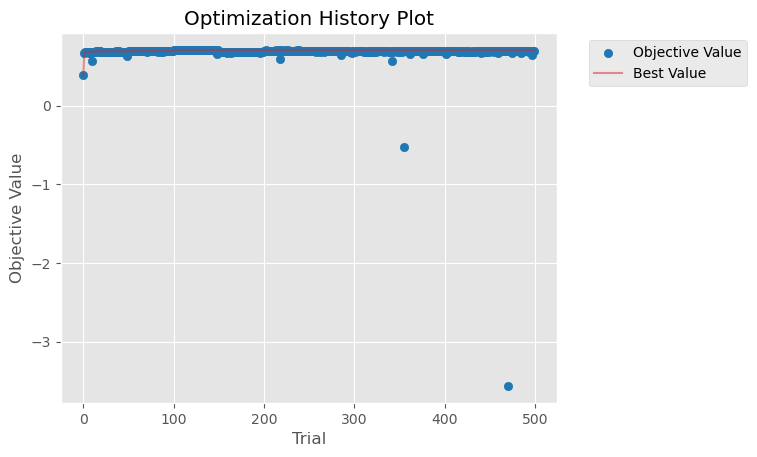

In [97]:
plot_optimization_history(study_xgb);

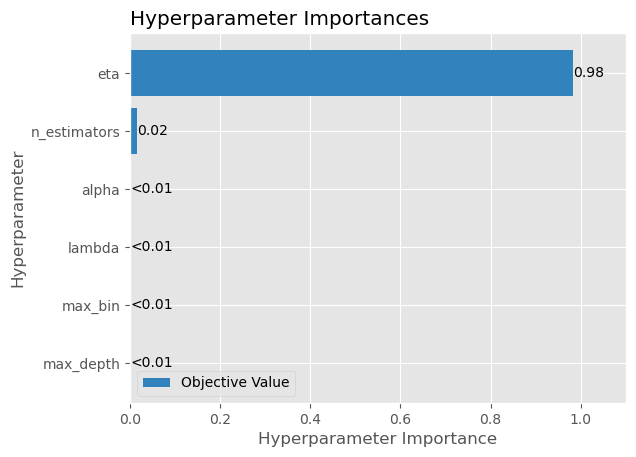

In [98]:
plot_param_importances(study_xgb);

In [99]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.720357,0.026407
1,TP,165.400000,10.394443
2,TN,89.800000,5.769652
3,FP,23.600000,6.058969
4,FN,18.300000,4.001389
5,Accuracy,0.858970,0.032930
6,Precision,0.874620,0.034974
7,Sensitivity,0.899715,0.025559
8,Specificity,0.792980,0.043536
9,F1 score,0.886929,0.029915


In [100]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.733450,0.709249,0.685721,0.744080,0.680602,0.715920,0.704537,0.695594,0.717151,0.715255,0.710156,0.019767
1,TP,349.000000,326.000000,335.000000,333.000000,334.000000,345.000000,329.000000,330.000000,319.000000,333.000000,333.300000,8.654479
2,TN,168.000000,175.000000,172.000000,183.000000,173.000000,176.000000,175.000000,165.000000,183.000000,182.000000,175.200000,6.142746
3,FP,44.000000,55.000000,50.000000,43.000000,58.000000,42.000000,53.000000,55.000000,59.000000,49.000000,50.800000,6.214678
4,FN,34.000000,39.000000,38.000000,36.000000,30.000000,32.000000,38.000000,45.000000,34.000000,31.000000,35.700000,4.498148
5,Accuracy,0.868908,0.842017,0.852101,0.867227,0.852101,0.875630,0.847059,0.831933,0.843697,0.865546,0.854622,0.014089
6,Precision,0.888041,0.855643,0.870130,0.885638,0.852041,0.891473,0.861257,0.857143,0.843915,0.871728,0.867701,0.016439
7,Sensitivity,0.911227,0.893151,0.898123,0.902439,0.917582,0.915119,0.896458,0.880000,0.903683,0.914835,0.903262,0.011832
8,Specificity,0.792500,0.760900,0.774800,0.809700,0.748900,0.807300,0.767500,0.750000,0.756200,0.787900,0.775570,0.022685
9,F1 score,0.899485,0.873995,0.883905,0.893960,0.883598,0.903141,0.878505,0.868421,0.872777,0.892761,0.885055,0.011880


In [101]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["rmse"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
xgb_5preds = pd.concat([chembl_id, xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
xgb_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_xgb0,y_pred_xgb1,y_pred_xgb2,y_pred_xgb3,y_pred_xgb4,y_pred_xgb_ave,y_pred_xgb_std
0,CHEMBL4084049,0,6.26,8.758532,8.784937,9.329721,8.791228,8.777309,8.450288,1.000079
1,CHEMBL2178343,1,5.96,5.876702,6.181002,5.856022,5.723582,5.844631,5.906990,0.140792
2,CHEMBL454672,2,6.80,6.450893,6.372425,6.311010,6.516962,6.680537,6.521971,0.170484
3,CHEMBL4299417,3,8.14,7.459725,7.450311,7.620901,7.762241,7.369499,7.633780,0.260361
4,CHEMBL3692580,4,5.24,5.672783,5.919975,5.909253,5.757923,5.891068,5.731834,0.237451
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL3775269,2966,7.40,6.757438,6.755647,6.088509,6.794027,6.651505,6.741188,0.381080
2967,CHEMBL3339019,2967,8.07,8.239470,7.852266,8.144821,8.125732,8.141168,8.095576,0.119703
2968,CHEMBL3771312,2968,6.52,6.254598,6.044411,6.240855,6.159820,6.196447,6.236022,0.144395
2969,CHEMBL3589701,2969,6.49,7.020974,7.020853,6.991595,7.008939,6.980704,6.918844,0.192345


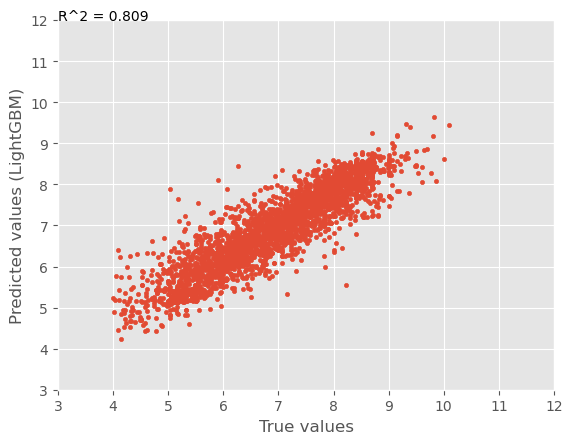

In [102]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'])), (3, 12))
plt.show()

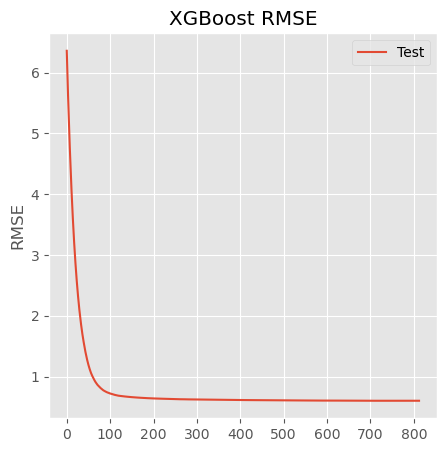

In [103]:
from matplotlib import pyplot
import matplotlib.pyplot as plt  
# retrieve performance metrics
results = optimized_xgb_0.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

 # plot classification error
#fig, ax = pyplot.subplots(figsize=(5,5))
#ax.plot(x_axis, results['validation_0']['error'], label='Train')
#ax.plot(x_axis, results['validation_1']['error'], label='Test')
#ax.legend()
    
#pyplot.ylabel('Classification Error')
#pyplot.title('XGBoost Classification Error')
#pyplot.show()

In [104]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_reg, X, Y, cv=10, scoring="r2", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
print("XGBoost baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

XGBoost baseline model r2_score 0.6498 with a standard deviation of 0.0344
XGBoost optimized model r2_score 0.7140 with a standard deviation of 0.0265


In [105]:
joblib.dump(xgb_reg, "OUTPUT/xgb_reg.joblib")
#joblib.dump(optimized_xgb, "OUTPUT/optimized_xgb.joblib")
joblib.dump(optimizedCV_xgb, "OUTPUT/optimizedCV_xgb.joblib")


['OUTPUT/optimizedCV_xgb.joblib']

## KNeighbors (KNN)

In [106]:
%%time


r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_reg = KNeighborsRegressor()
    
    knn_reg.fit(X_train,y_train)

    y_pred = knn_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.637460     0.029924
1                    TP       163.800000     9.307106
2                    TN        81.600000     4.599517
3                    FP        31.800000     4.685676
4                    FN        19.900000     4.748099
5              Accuracy         0.825993     0.022815
6             Precision         0.837056     0.026363
7           Sensitivity         0.891376     0.026515
8           Specificity         0.720460     0.029060
9              F1 score         0.863135     0.021845
10  F1 score (weighted)         0.823946     0.022766
11     F1 score (macro)         0.811518     0.021414
12    Balanced Accuracy         0.805920     0.020142
13                  MCC         0.626924     0.043524
14                  NPV         0.805480     0.038829
15              ROC_AUC         0.805920     0.020142
CPU times: user 3.01 s, sys: 7.56 s, total: 10.6 s
Wall time: 374 ms


In [107]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [108]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),      
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [109]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNregressor")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:01:36,554] A new study created in memory with name: KNNregressor
[I 2023-12-20 14:01:36,780] Trial 0 finished with value: 0.5823101921648949 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 80}. Best is trial 0 with value: 0.5823101921648949.
[I 2023-12-20 14:01:37,262] Trial 1 finished with value: 0.5066941880927178 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 75}. Best is trial 0 with value: 0.5823101921648949.
[I 2023-12-20 14:01:37,461] Trial 2 finished with value: 0.5262759924393624 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 55}. Best is trial 0 with value: 0.5823101921648949.
[I 2023-12-20 14:01:37,662] Trial 3 finished with value: 0.5505914056917073 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 51}. Best is trial 0 with value: 0.5823101921648949.
[I 2023-12-20 14:01:38,08

	Number of trials: 50.0
	Best value (r2_score): 0.6262
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 100


In [110]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_knn_0)
# now convert the resuls to binary with cutoff 
y_pred_knn_0_cat = np.where((y_pred_knn_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_knn_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_knn_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_knn_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_knn_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_knn_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_knn_0_cat)
    

mat_met_knn_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    R2    0.661926
1                    TP  341.000000
2                    TN  161.000000
3                    FP   51.000000
4                    FN   42.000000
5              Accuracy    0.843697
6             Precision    0.869898
7           Sensitivity    0.890339
8           Specificity    0.759400
9              F1 score    0.880000
10  F1 score (weighted)    0.842910
11     F1 score (macro)    0.827952
12    Balanced Accuracy    0.824887
13                  MCC    0.656354
14                  NPV    0.793100
15              ROC_AUC    0.824887


In [111]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:01:57,329] Trial 50 finished with value: 0.6222750741265637 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 46}. Best is trial 12 with value: 0.6261758476377135.
[I 2023-12-20 14:01:57,850] Trial 51 finished with value: 0.6243489896683279 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 94}. Best is trial 12 with value: 0.6261758476377135.
[I 2023-12-20 14:01:58,351] Trial 52 finished with value: 0.6243489896683279 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 12 with value: 0.6261758476377135.
[I 2023-12-20 14:01:58,853] Trial 53 finished with value: 0.6200758461806724 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 12 with value: 0.6261758476377135.
[I 2023-12-20 14:01:59,334] Trial 54 finished with value: 0.6222750741265637 and parameters: {'n_ne

	Number of trials: 100.0
	Best value (r2_score): 0.6262
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 100


In [112]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_knn_1)
# now convert the resuls to binary with cutoff 
y_pred_knn_1_cat = np.where((y_pred_knn_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_knn_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_knn_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_knn_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_knn_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_knn_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_knn_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    R2    0.661926    0.678335
1                    TP  341.000000  336.000000
2                    TN  161.000000  169.000000
3                    FP   51.000000   61.000000
4                    FN   42.000000   29.000000
5              Accuracy    0.843697    0.848739
6             Precision    0.869898    0.846348
7           Sensitivity    0.890339    0.920548
8           Specificity    0.759400    0.734800
9              F1 score    0.880000    0.881890
10  F1 score (weighted)    0.842910    0.846261
11     F1 score (macro)    0.827952    0.835805
12    Balanced Accuracy    0.824887    0.827665
13                  MCC    0.656354    0.677240
14                  NPV    0.793100    0.853500
15              ROC_AUC    0.824887    0.827665


In [113]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:02:19,708] Trial 100 finished with value: 0.6363010333218743 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 46}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:20,199] Trial 101 finished with value: 0.6363010333218743 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 51}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:20,723] Trial 102 finished with value: 0.6363010333218743 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 51}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:21,238] Trial 103 finished with value: 0.6363010333218743 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 52}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:21,763] Trial 104 finished with value: 0.6363010333218743 and parameters

	Number of trials: 150.0
	Best value (r2_score): 0.6363
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 46


In [114]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_knn_2)
# now convert the resuls to binary with cutoff 
y_pred_knn_2_cat = np.where((y_pred_knn_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_knn_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_knn_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_knn_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_knn_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_knn_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_knn_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.661926    0.678335    0.647956
1                    TP  341.000000  336.000000  332.000000
2                    TN  161.000000  169.000000  170.000000
3                    FP   51.000000   61.000000   52.000000
4                    FN   42.000000   29.000000   41.000000
5              Accuracy    0.843697    0.848739    0.843697
6             Precision    0.869898    0.846348    0.864583
7           Sensitivity    0.890339    0.920548    0.890080
8           Specificity    0.759400    0.734800    0.765800
9              F1 score    0.880000    0.881890    0.877147
10  F1 score (weighted)    0.842910    0.846261    0.842848
11     F1 score (macro)    0.827952    0.835805    0.831183
12    Balanced Accuracy    0.824887    0.827665    0.827923
13                  MCC    0.656354    0.677240    0.663019
14                  NPV    0.793100    0.853500    0.805700
15              ROC_AUC    0.824887    0

In [115]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:02:43,907] Trial 150 finished with value: 0.6235227263789899 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 47}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:44,345] Trial 151 finished with value: 0.6235227263789899 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 51}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:44,756] Trial 152 finished with value: 0.6235227263789899 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 47}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:45,170] Trial 153 finished with value: 0.6242172085556572 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 100 with value: 0.6363010333218743.
[I 2023-12-20 14:02:45,588] Trial 154 finished with value: 0.6046412833122836 and parameters

	Number of trials: 200.0
	Best value (r2_score): 0.6363
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 46


In [116]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_knn_3)
# now convert the resuls to binary with cutoff 
y_pred_knn_3_cat = np.where((y_pred_knn_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_knn_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_knn_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_knn_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_knn_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_knn_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_knn_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.661926    0.678335    0.647956    0.697543
1                    TP  341.000000  336.000000  332.000000  334.000000
2                    TN  161.000000  169.000000  170.000000  169.000000
3                    FP   51.000000   61.000000   52.000000   57.000000
4                    FN   42.000000   29.000000   41.000000   35.000000
5              Accuracy    0.843697    0.848739    0.843697    0.845378
6             Precision    0.869898    0.846348    0.864583    0.854220
7           Sensitivity    0.890339    0.920548    0.890080    0.905149
8           Specificity    0.759400    0.734800    0.765800    0.747800
9              F1 score    0.880000    0.881890    0.877147    0.878947
10  F1 score (weighted)    0.842910    0.846261    0.842848    0.843661
11     F1 score (macro)    0.827952    0.835805    0.831183    0.832497
12    Balanced Accuracy    0.824887    0.827665    0.827923    0

In [117]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:03:06,929] Trial 200 finished with value: 0.6479457806927199 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 34}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:07,434] Trial 201 finished with value: 0.6479457806927199 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 53}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:07,929] Trial 202 finished with value: 0.6479457806927199 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 33}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:08,444] Trial 203 finished with value: 0.6479457806927199 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 30}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:08,949] Trial 204 finished with value: 0.6479457806927199 and parameters

	Number of trials: 250.0
	Best value (r2_score): 0.6479
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 34


In [118]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_knn_4)
# now convert the resuls to binary with cutoff 
y_pred_knn_4_cat = np.where((y_pred_knn_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_knn_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_knn_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_knn_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_knn_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_knn_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_knn_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.661926    0.678335    0.647956    0.697543   
1                    TP  341.000000  336.000000  332.000000  334.000000   
2                    TN  161.000000  169.000000  170.000000  169.000000   
3                    FP   51.000000   61.000000   52.000000   57.000000   
4                    FN   42.000000   29.000000   41.000000   35.000000   
5              Accuracy    0.843697    0.848739    0.843697    0.845378   
6             Precision    0.869898    0.846348    0.864583    0.854220   
7           Sensitivity    0.890339    0.920548    0.890080    0.905149   
8           Specificity    0.759400    0.734800    0.765800    0.747800   
9              F1 score    0.880000    0.881890    0.877147    0.878947   
10  F1 score (weighted)    0.842910    0.846261    0.842848    0.843661   
11     F1 score (macro)    0.827952    0.835805    0.831183    0.832497   
12    Balanced Accuracy  

In [119]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:03:30,889] Trial 250 finished with value: 0.6332199095096005 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 26}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:31,374] Trial 251 finished with value: 0.6332199095096005 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 28}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:31,868] Trial 252 finished with value: 0.6157069412110296 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 25}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:32,363] Trial 253 finished with value: 0.6332199095096005 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 22}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:32,860] Trial 254 finished with value: 0.6332199095096005 and parameters:

	Number of trials: 300.0
	Best value (r2_score): 0.6479
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 34


In [120]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_knn_5)
# now convert the resuls to binary with cutoff 
y_pred_knn_5_cat = np.where((y_pred_knn_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_knn_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_knn_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_knn_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_knn_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_knn_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_knn_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.661926    0.678335    0.647956    0.697543   
1                    TP  341.000000  336.000000  332.000000  334.000000   
2                    TN  161.000000  169.000000  170.000000  169.000000   
3                    FP   51.000000   61.000000   52.000000   57.000000   
4                    FN   42.000000   29.000000   41.000000   35.000000   
5              Accuracy    0.843697    0.848739    0.843697    0.845378   
6             Precision    0.869898    0.846348    0.864583    0.854220   
7           Sensitivity    0.890339    0.920548    0.890080    0.905149   
8           Specificity    0.759400    0.734800    0.765800    0.747800   
9              F1 score    0.880000    0.881890    0.877147    0.878947   
10  F1 score (weighted)    0.842910    0.846261    0.842848    0.843661   
11     F1 score (macro)    0.827952    0.835805    0.831183    0.832497   
12    Balanced Accuracy  

In [121]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:03:54,591] Trial 300 finished with value: 0.6290989875609789 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 34}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:55,100] Trial 301 finished with value: 0.6332637323209335 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 25}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:55,609] Trial 302 finished with value: 0.6332637323209335 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 32}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:56,120] Trial 303 finished with value: 0.6332637323209335 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 28}. Best is trial 200 with value: 0.6479457806927199.
[I 2023-12-20 14:03:56,619] Trial 304 finished with value: 0.5903187751514922 and parameters

	Number of trials: 350.0
	Best value (r2_score): 0.6479
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 34


In [122]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_knn_6)
# now convert the resuls to binary with cutoff 
y_pred_knn_6_cat = np.where((y_pred_knn_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_knn_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_knn_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_knn_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_knn_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_knn_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_knn_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.661926    0.678335    0.647956    0.697543   
1                    TP  341.000000  336.000000  332.000000  334.000000   
2                    TN  161.000000  169.000000  170.000000  169.000000   
3                    FP   51.000000   61.000000   52.000000   57.000000   
4                    FN   42.000000   29.000000   41.000000   35.000000   
5              Accuracy    0.843697    0.848739    0.843697    0.845378   
6             Precision    0.869898    0.846348    0.864583    0.854220   
7           Sensitivity    0.890339    0.920548    0.890080    0.905149   
8           Specificity    0.759400    0.734800    0.765800    0.747800   
9              F1 score    0.880000    0.881890    0.877147    0.878947   
10  F1 score (weighted)    0.842910    0.846261    0.842848    0.843661   
11     F1 score (macro)    0.827952    0.835805    0.831183    0.832497   
12    Balanced Accuracy  

In [123]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:04:18,301] Trial 350 finished with value: 0.6487213913834766 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 25}. Best is trial 350 with value: 0.6487213913834766.
[I 2023-12-20 14:04:18,776] Trial 351 finished with value: 0.5902543768934779 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 25}. Best is trial 350 with value: 0.6487213913834766.
[I 2023-12-20 14:04:19,206] Trial 352 finished with value: 0.6489391696349673 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 24}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:04:19,430] Trial 353 finished with value: 0.6332654719015018 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 22}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:04:19,894] Trial 354 finished with value: 0.6489391696349673 and parameter

	Number of trials: 400.0
	Best value (r2_score): 0.6489
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 24


In [124]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_knn_7)
# now convert the resuls to binary with cutoff 
y_pred_knn_7_cat = np.where((y_pred_knn_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_knn_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_knn_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_knn_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_knn_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_knn_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_knn_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.661926    0.678335    0.647956    0.697543   
1                    TP  341.000000  336.000000  332.000000  334.000000   
2                    TN  161.000000  169.000000  170.000000  169.000000   
3                    FP   51.000000   61.000000   52.000000   57.000000   
4                    FN   42.000000   29.000000   41.000000   35.000000   
5              Accuracy    0.843697    0.848739    0.843697    0.845378   
6             Precision    0.869898    0.846348    0.864583    0.854220   
7           Sensitivity    0.890339    0.920548    0.890080    0.905149   
8           Specificity    0.759400    0.734800    0.765800    0.747800   
9              F1 score    0.880000    0.881890    0.877147    0.878947   
10  F1 score (weighted)    0.842910    0.846261    0.842848    0.843661   
11     F1 score (macro)    0.827952    0.835805    0.831183    0.832497   
12    Balanced Accuracy  

In [125]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:04:42,328] Trial 400 finished with value: 0.6366106723197243 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:04:42,825] Trial 401 finished with value: 0.6393657670785843 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 66}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:04:43,332] Trial 402 finished with value: 0.6393657670785843 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:04:43,840] Trial 403 finished with value: 0.6366106723197243 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 62}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:04:44,349] Trial 404 finished with value: 0.6393657670785843 and parameters

	Number of trials: 450.0
	Best value (r2_score): 0.6489
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 24


In [126]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_knn_8)
# now convert the resuls to binary with cutoff 
y_pred_knn_8_cat = np.where((y_pred_knn_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_knn_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_knn_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_knn_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_knn_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_knn_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_knn_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.661926    0.678335    0.647956    0.697543   
1                    TP  341.000000  336.000000  332.000000  334.000000   
2                    TN  161.000000  169.000000  170.000000  169.000000   
3                    FP   51.000000   61.000000   52.000000   57.000000   
4                    FN   42.000000   29.000000   41.000000   35.000000   
5              Accuracy    0.843697    0.848739    0.843697    0.845378   
6             Precision    0.869898    0.846348    0.864583    0.854220   
7           Sensitivity    0.890339    0.920548    0.890080    0.905149   
8           Specificity    0.759400    0.734800    0.765800    0.747800   
9              F1 score    0.880000    0.881890    0.877147    0.878947   
10  F1 score (weighted)    0.842910    0.846261    0.842848    0.843661   
11     F1 score (macro)    0.827952    0.835805    0.831183    0.832497   
12    Balanced Accuracy  

In [127]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:05:05,597] Trial 450 finished with value: 0.6263455227122081 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 58}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:05:06,109] Trial 451 finished with value: 0.6409343576082964 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 65}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:05:06,628] Trial 452 finished with value: 0.6388598415223881 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 61}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:05:06,854] Trial 453 finished with value: 0.61239439511933 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 69}. Best is trial 352 with value: 0.6489391696349673.
[I 2023-12-20 14:05:07,323] Trial 454 finished with value: 0.6409343576082964 and parameters: {

	Number of trials: 500.0
	Best value (r2_score): 0.6489
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 24


In [128]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_knn_9)
# now convert the resuls to binary with cutoff 
y_pred_knn_9_cat = np.where((y_pred_knn_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_knn_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_knn_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_knn_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_knn_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_knn_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_knn_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.661926    0.678335    0.647956    0.697543   
1                    TP  341.000000  336.000000  332.000000  334.000000   
2                    TN  161.000000  169.000000  170.000000  169.000000   
3                    FP   51.000000   61.000000   52.000000   57.000000   
4                    FN   42.000000   29.000000   41.000000   35.000000   
5              Accuracy    0.843697    0.848739    0.843697    0.845378   
6             Precision    0.869898    0.846348    0.864583    0.854220   
7           Sensitivity    0.890339    0.920548    0.890080    0.905149   
8           Specificity    0.759400    0.734800    0.765800    0.747800   
9              F1 score    0.880000    0.881890    0.877147    0.878947   
10  F1 score (weighted)    0.842910    0.846261    0.842848    0.843661   
11     F1 score (macro)    0.827952    0.835805    0.831183    0.832497   
12    Balanced Accuracy  

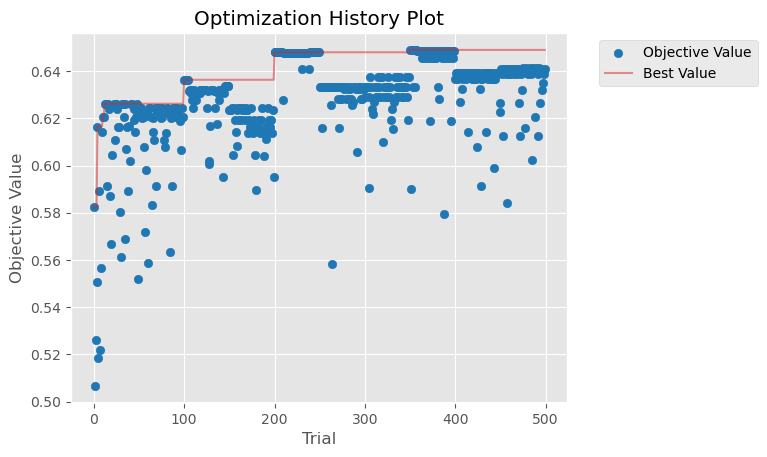

In [129]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

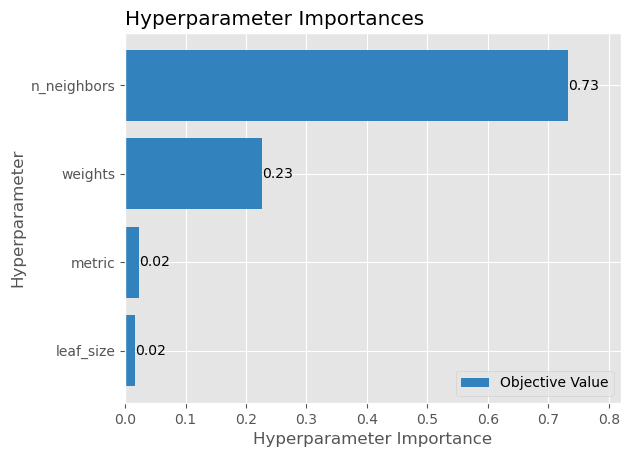

In [130]:

plot_param_importances(study_knn);

In [131]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.650994,0.032138
1,TP,165.600000,9.453982
2,TN,83.900000,4.581363
3,FP,29.500000,4.904646
4,FN,18.100000,4.629615
5,Accuracy,0.839792,0.025938
6,Precision,0.848356,0.028102
7,Sensitivity,0.901135,0.026089
8,Specificity,0.740860,0.030746
9,F1 score,0.873775,0.023872


In [132]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.661926,0.678335,0.647956,0.697543,0.603395,0.669008,0.663318,0.647779,0.606425,0.640998,0.651668,0.029584
1,TP,341.000000,336.000000,332.000000,334.000000,332.000000,342.000000,334.000000,339.000000,320.000000,328.000000,333.800000,6.511528
2,TN,161.000000,169.000000,170.000000,169.000000,152.000000,170.000000,167.000000,153.000000,170.000000,176.000000,165.700000,7.860591
3,FP,51.000000,61.000000,52.000000,57.000000,79.000000,48.000000,61.000000,67.000000,72.000000,55.000000,60.300000,9.877584
4,FN,42.000000,29.000000,41.000000,35.000000,32.000000,35.000000,33.000000,36.000000,33.000000,36.000000,35.200000,3.938415
5,Accuracy,0.843697,0.848739,0.843697,0.845378,0.813445,0.860504,0.842017,0.826891,0.823529,0.847059,0.839496,0.013955
6,Precision,0.869898,0.846348,0.864583,0.854220,0.807786,0.876923,0.845570,0.834975,0.816327,0.856397,0.847303,0.022346
7,Sensitivity,0.890339,0.920548,0.890080,0.905149,0.912088,0.907162,0.910082,0.904000,0.906516,0.901099,0.904706,0.009296
8,Specificity,0.759400,0.734800,0.765800,0.747800,0.658000,0.779800,0.732500,0.695500,0.702500,0.761900,0.733800,0.037971
9,F1 score,0.880000,0.881890,0.877147,0.878947,0.856774,0.891786,0.876640,0.868118,0.859060,0.878179,0.874854,0.010649


In [133]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
knn_5preds = pd.concat([chembl_id, knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL4084049,0,6.26,8.314242,8.580536,8.713683,8.345944,8.314242,8.088108,0.831120
1,CHEMBL2178343,1,5.96,5.692657,5.714293,5.462840,5.462840,5.692657,5.664215,0.169665
2,CHEMBL454672,2,6.80,6.429171,6.407538,6.339414,6.339414,6.407538,6.453846,0.158593
3,CHEMBL4299417,3,8.14,7.110000,7.110000,7.149945,7.146060,7.110000,7.294334,0.378577
4,CHEMBL3692580,4,5.24,5.328651,5.397189,5.328651,5.368068,5.322712,5.330878,0.048504
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL3775269,2966,7.40,7.416433,7.416433,7.139804,7.416433,7.478761,7.377978,0.109396
2967,CHEMBL3339019,2967,8.07,7.928212,8.050778,7.966713,7.977354,7.985335,7.996399,0.048973
2968,CHEMBL3771312,2968,6.52,5.985449,5.985449,5.985449,5.972569,6.029393,6.079718,0.197704
2969,CHEMBL3589701,2969,6.49,6.121612,5.960083,6.121612,6.121612,6.207435,6.170392,0.160670


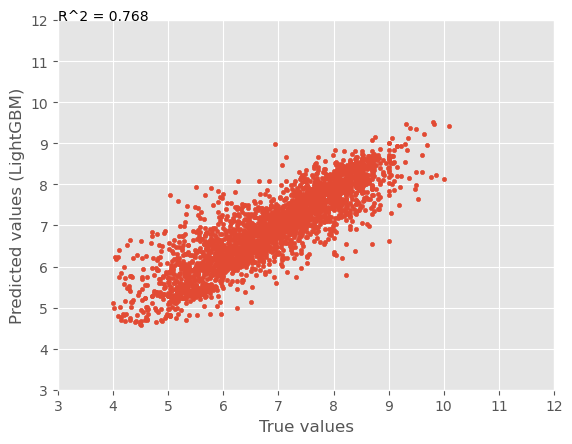

In [134]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'])), (3, 12))
plt.show()

In [135]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_reg, X, Y, cv=10, scoring="r2")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="r2")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="r2")
print("KNN baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model r2_score 0.6466 with a standard deviation of 0.0297
KNN optimized model r2_score 0.6573 with a standard deviation of 0.0222


In [136]:
joblib.dump(knn_reg, "OUTPUT/knn_reg.joblib")
#joblib.dump(optimized_knn, "OUTPUT/optimized_knn.joblib")
joblib.dump(optimizedCV_knn, "OUTPUT/optimizedCV_knn.joblib")
#loaded_rf = joblib.load("OUTPUT/optimized_rf.joblib")

['OUTPUT/optimizedCV_knn.joblib']

## Support Vector 

In [137]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_reg = SVR()
    
    svm_reg.fit(X_train, y_train, )

    y_pred = svm_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.691559     0.022876
1                    TP       165.100000    10.343543
2                    TN        85.900000     5.724218
3                    FP        27.500000     4.169999
4                    FN        18.600000     4.247875
5              Accuracy         0.844843     0.026360
6             Precision         0.856622     0.025192
7           Sensitivity         0.898135     0.025995
8           Specificity         0.757970     0.029203
9              F1 score         0.876838     0.024574
10  F1 score (weighted)         0.843525     0.026428
11     F1 score (macro)         0.832892     0.025758
12    Balanced Accuracy         0.828047     0.024767
13                  MCC         0.667698     0.051819
14                  NPV         0.822930     0.034363
15              ROC_AUC         0.828047     0.024767
CPU times: user 9.66 s, sys: 4 ms, total: 9.66 s
Wall time: 9.66 s


In [138]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)


In [139]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [140]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_regressor_CV")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:05:46,592] A new study created in memory with name: SVM_regressor_CV
[I 2023-12-20 14:05:52,760] Trial 0 finished with value: 0.3426338352793038 and parameters: {'C': 0.5, 'gamma': 0.00048828125}. Best is trial 0 with value: 0.3426338352793038.
[I 2023-12-20 14:05:59,068] Trial 1 finished with value: 0.1438927384545503 and parameters: {'C': 0.0625, 'gamma': 0.0625}. Best is trial 0 with value: 0.3426338352793038.
[I 2023-12-20 14:06:05,162] Trial 2 finished with value: 0.34758069504845274 and parameters: {'C': 8.0, 'gamma': 3.0517578125e-05}. Best is trial 2 with value: 0.34758069504845274.
[I 2023-12-20 14:06:11,084] Trial 3 finished with value: 0.434676215199475 and parameters: {'C': 8.0, 'gamma': 6.103515625e-05}. Best is trial 3 with value: 0.434676215199475.
[I 2023-12-20 14:06:17,350] Trial 4 finished with value: 0.08191806173880276 and parameters: {'C': 0.0078125, 'gamma': 0.0078125}. Best is trial 3 with value: 0.434676215199475.
[I 2023-12-20 14:06:23,804] Tri

	Number of trials: 50.0
	Best value (r2_score): 0.6761
	Best params:
		C: 32.0
		gamma: 0.015625


In [141]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_svm_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_0_cat = np.where((y_pred_svm_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_svm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_svm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_svm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_svm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_svm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_svm_0_cat)
    

mat_met_svm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    R2    0.720102
1                    TP  345.000000
2                    TN  167.000000
3                    FP   45.000000
4                    FN   38.000000
5              Accuracy    0.860504
6             Precision    0.884615
7           Sensitivity    0.900783
8           Specificity    0.787700
9              F1 score    0.892626
10  F1 score (weighted)    0.859965
11     F1 score (macro)    0.846793
12    Balanced Accuracy    0.844260
13                  MCC    0.693864
14                  NPV    0.814600
15              ROC_AUC    0.844260


In [142]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:11:19,794] Trial 50 finished with value: 0.02003868620953946 and parameters: {'C': 32.0, 'gamma': 1.0}. Best is trial 40 with value: 0.6761120797908642.
[I 2023-12-20 14:11:26,278] Trial 51 finished with value: 0.6854062244733852 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 51 with value: 0.6854062244733852.
[I 2023-12-20 14:11:32,753] Trial 52 finished with value: 0.6854062244733852 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 51 with value: 0.6854062244733852.
[I 2023-12-20 14:11:40,014] Trial 53 finished with value: 0.013128252146970377 and parameters: {'C': 32.0, 'gamma': 2.0}. Best is trial 51 with value: 0.6854062244733852.
[I 2023-12-20 14:11:46,492] Trial 54 finished with value: 0.6854062244733852 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 51 with value: 0.6854062244733852.
[I 2023-12-20 14:11:52,766] Trial 55 finished with value: 0.5490573780481174 and parameters: {'C': 8.0, 'gamma': 0.000244140625}. Best is

	Number of trials: 100.0
	Best value (r2_score): 0.6968
	Best params:
		C: 4.0
		gamma: 0.015625


In [143]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_svm_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_1_cat = np.where((y_pred_svm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_svm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_svm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_svm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_svm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_svm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_svm_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    R2    0.720102    0.712450
1                    TP  345.000000  334.000000
2                    TN  167.000000  170.000000
3                    FP   45.000000   60.000000
4                    FN   38.000000   31.000000
5              Accuracy    0.860504    0.847059
6             Precision    0.884615    0.847716
7           Sensitivity    0.900783    0.915068
8           Specificity    0.787700    0.739100
9              F1 score    0.892626    0.880105
10  F1 score (weighted)    0.859965    0.844835
11     F1 score (macro)    0.846793    0.834484
12    Balanced Accuracy    0.844260    0.827099
13                  MCC    0.693864    0.673557
14                  NPV    0.814600    0.845800
15              ROC_AUC    0.844260    0.827099


In [144]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:16:42,996] Trial 100 finished with value: 0.5938516068674138 and parameters: {'C': 4.0, 'gamma': 0.0009765625}. Best is trial 76 with value: 0.696802065242923.
[I 2023-12-20 14:16:48,882] Trial 101 finished with value: 0.7009185511601342 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:16:54,764] Trial 102 finished with value: 0.7009185511601342 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:17:00,628] Trial 103 finished with value: 0.7009185511601342 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:17:06,426] Trial 104 finished with value: 0.55862995006968 and parameters: {'C': 4.0, 'gamma': 0.00048828125}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:17:12,356] Trial 105 finished with value: 0.7009185511601342 and parameters: {'C': 4.0, 'gamma': 0.0156

	Number of trials: 150.0
	Best value (r2_score): 0.7009
	Best params:
		C: 4.0
		gamma: 0.015625


In [145]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_svm_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_2_cat = np.where((y_pred_svm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_svm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_svm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_svm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_svm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_svm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_svm_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.720102    0.712450    0.690328
1                    TP  345.000000  334.000000  340.000000
2                    TN  167.000000  170.000000  173.000000
3                    FP   45.000000   60.000000   49.000000
4                    FN   38.000000   31.000000   33.000000
5              Accuracy    0.860504    0.847059    0.862185
6             Precision    0.884615    0.847716    0.874036
7           Sensitivity    0.900783    0.915068    0.911528
8           Specificity    0.787700    0.739100    0.779300
9              F1 score    0.892626    0.880105    0.892388
10  F1 score (weighted)    0.859965    0.844835    0.861056
11     F1 score (macro)    0.846793    0.834484    0.850400
12    Balanced Accuracy    0.844260    0.827099    0.845404
13                  MCC    0.693864    0.673557    0.702230
14                  NPV    0.814600    0.845800    0.839800
15              ROC_AUC    0.844260    0

In [146]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:21:40,758] Trial 150 finished with value: 0.6728936072831033 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:21:47,241] Trial 151 finished with value: 0.27553453542165657 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:21:53,086] Trial 152 finished with value: 0.6279422680944446 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:21:59,495] Trial 153 finished with value: 0.6650204130864111 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:22:06,041] Trial 154 finished with value: 0.6728936072831033 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:22:12,294] Trial 155 finished with value: 0.4350504583881518 and parameters: {'C': 8.0, 'gamma': 6.103

	Number of trials: 200.0
	Best value (r2_score): 0.7009
	Best params:
		C: 4.0
		gamma: 0.015625


In [147]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_svm_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_3_cat = np.where((y_pred_svm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_svm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_svm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_svm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_svm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_svm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_svm_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.720102    0.712450    0.690328    0.730473
1                    TP  345.000000  334.000000  340.000000  336.000000
2                    TN  167.000000  170.000000  173.000000  181.000000
3                    FP   45.000000   60.000000   49.000000   45.000000
4                    FN   38.000000   31.000000   33.000000   33.000000
5              Accuracy    0.860504    0.847059    0.862185    0.868908
6             Precision    0.884615    0.847716    0.874036    0.881890
7           Sensitivity    0.900783    0.915068    0.911528    0.910569
8           Specificity    0.787700    0.739100    0.779300    0.800900
9              F1 score    0.892626    0.880105    0.892388    0.896000
10  F1 score (weighted)    0.859965    0.844835    0.861056    0.868169
11     F1 score (macro)    0.846793    0.834484    0.850400    0.859364
12    Balanced Accuracy    0.844260    0.827099    0.845404    0

In [148]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:27:01,794] Trial 200 finished with value: 0.14399515316153116 and parameters: {'C': 0.125, 'gamma': 0.00048828125}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:27:07,699] Trial 201 finished with value: 0.6963755607727274 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:27:13,658] Trial 202 finished with value: 0.6963755607727274 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:27:19,614] Trial 203 finished with value: 0.6963755607727274 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:27:25,718] Trial 204 finished with value: 0.7009167596645087 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:27:31,814] Trial 205 finished with value: 0.7009167596645087 and parameters: {'C': 4.0, 'gamma': 0.0

	Number of trials: 250.0
	Best value (r2_score): 0.7009
	Best params:
		C: 4.0
		gamma: 0.015625


In [149]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_svm_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_4_cat = np.where((y_pred_svm_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_svm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_svm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_svm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_svm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_svm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_svm_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.720102    0.712450    0.690328    0.730473   
1                    TP  345.000000  334.000000  340.000000  336.000000   
2                    TN  167.000000  170.000000  173.000000  181.000000   
3                    FP   45.000000   60.000000   49.000000   45.000000   
4                    FN   38.000000   31.000000   33.000000   33.000000   
5              Accuracy    0.860504    0.847059    0.862185    0.868908   
6             Precision    0.884615    0.847716    0.874036    0.881890   
7           Sensitivity    0.900783    0.915068    0.911528    0.910569   
8           Specificity    0.787700    0.739100    0.779300    0.800900   
9              F1 score    0.892626    0.880105    0.892388    0.896000   
10  F1 score (weighted)    0.859965    0.844835    0.861056    0.868169   
11     F1 score (macro)    0.846793    0.834484    0.850400    0.859364   
12    Balanced Accuracy  

In [150]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:32:09,518] Trial 250 finished with value: 0.09016447081080263 and parameters: {'C': 4.0, 'gamma': 0.25}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:32:16,133] Trial 251 finished with value: 0.6900366134880949 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:32:23,306] Trial 252 finished with value: 0.03999394393869602 and parameters: {'C': 4.0, 'gamma': 1.0}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:32:29,881] Trial 253 finished with value: 0.6900366134880949 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:32:36,107] Trial 254 finished with value: 0.5051001176146578 and parameters: {'C': 4.0, 'gamma': 0.000244140625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:32:42,722] Trial 255 finished with value: 0.6900366134880949 and parameters: {'C': 4.0, 'gamma': 0.015625}. B

	Number of trials: 300.0
	Best value (r2_score): 0.7009
	Best params:
		C: 4.0
		gamma: 0.015625


In [151]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_svm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_5_cat = np.where((y_pred_svm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_svm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_svm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_svm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_svm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_svm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_svm_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.720102    0.712450    0.690328    0.730473   
1                    TP  345.000000  334.000000  340.000000  336.000000   
2                    TN  167.000000  170.000000  173.000000  181.000000   
3                    FP   45.000000   60.000000   49.000000   45.000000   
4                    FN   38.000000   31.000000   33.000000   33.000000   
5              Accuracy    0.860504    0.847059    0.862185    0.868908   
6             Precision    0.884615    0.847716    0.874036    0.881890   
7           Sensitivity    0.900783    0.915068    0.911528    0.910569   
8           Specificity    0.787700    0.739100    0.779300    0.800900   
9              F1 score    0.892626    0.880105    0.892388    0.896000   
10  F1 score (weighted)    0.859965    0.844835    0.861056    0.868169   
11     F1 score (macro)    0.846793    0.834484    0.850400    0.859364   
12    Balanced Accuracy  

In [152]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:37:39,804] Trial 300 finished with value: 0.698577105415312 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:37:45,852] Trial 301 finished with value: 0.4391141932842942 and parameters: {'C': 0.125, 'gamma': 0.03125}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:37:51,890] Trial 302 finished with value: 0.698577105415312 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:37:57,667] Trial 303 finished with value: 0.5945140017568091 and parameters: {'C': 4.0, 'gamma': 0.0009765625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:38:03,811] Trial 304 finished with value: 0.698577105415312 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7009185511601342.
[I 2023-12-20 14:38:10,568] Trial 305 finished with value: 0.038473883074328384 and parameters: {'C': 4.0, 'gamma': 0.5}. B

	Number of trials: 350.0
	Best value (r2_score): 0.7009
	Best params:
		C: 4.0
		gamma: 0.015625


In [153]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_svm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_6_cat = np.where((y_pred_svm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_svm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_svm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_svm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_svm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_svm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_svm_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.720102    0.712450    0.690328    0.730473   
1                    TP  345.000000  334.000000  340.000000  336.000000   
2                    TN  167.000000  170.000000  173.000000  181.000000   
3                    FP   45.000000   60.000000   49.000000   45.000000   
4                    FN   38.000000   31.000000   33.000000   33.000000   
5              Accuracy    0.860504    0.847059    0.862185    0.868908   
6             Precision    0.884615    0.847716    0.874036    0.881890   
7           Sensitivity    0.900783    0.915068    0.911528    0.910569   
8           Specificity    0.787700    0.739100    0.779300    0.800900   
9              F1 score    0.892626    0.880105    0.892388    0.896000   
10  F1 score (weighted)    0.859965    0.844835    0.861056    0.868169   
11     F1 score (macro)    0.846793    0.834484    0.850400    0.859364   
12    Balanced Accuracy  

In [154]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:42:47,753] Trial 350 finished with value: 0.7013628681027785 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:42:53,802] Trial 351 finished with value: 0.6354155827393676 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:43:00,077] Trial 352 finished with value: 0.2797927106663252 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:43:06,538] Trial 353 finished with value: 0.2474140995210748 and parameters: {'C': 4.0, 'gamma': 3.0517578125e-05}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:43:13,681] Trial 354 finished with value: 0.5873118368754955 and parameters: {'C': 64.0, 'gamma': 0.00048828125}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:43:19,874] Trial 355 finished with value: 0.3534187147552219 and parameters: {'C': 4.0, 'g

	Number of trials: 400.0
	Best value (r2_score): 0.7014
	Best params:
		C: 4.0
		gamma: 0.015625


In [155]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_svm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_7_cat = np.where((y_pred_svm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_svm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_svm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_svm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_svm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_svm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_svm_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.720102    0.712450    0.690328    0.730473   
1                    TP  345.000000  334.000000  340.000000  336.000000   
2                    TN  167.000000  170.000000  173.000000  181.000000   
3                    FP   45.000000   60.000000   49.000000   45.000000   
4                    FN   38.000000   31.000000   33.000000   33.000000   
5              Accuracy    0.860504    0.847059    0.862185    0.868908   
6             Precision    0.884615    0.847716    0.874036    0.881890   
7           Sensitivity    0.900783    0.915068    0.911528    0.910569   
8           Specificity    0.787700    0.739100    0.779300    0.800900   
9              F1 score    0.892626    0.880105    0.892388    0.896000   
10  F1 score (weighted)    0.859965    0.844835    0.861056    0.868169   
11     F1 score (macro)    0.846793    0.834484    0.850400    0.859364   
12    Balanced Accuracy  

In [156]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:48:14,322] Trial 400 finished with value: 0.041294397815867225 and parameters: {'C': 4.0, 'gamma': 0.5}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:48:20,282] Trial 401 finished with value: 0.6887294773600174 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:48:26,219] Trial 402 finished with value: 0.6887294773600174 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:48:32,130] Trial 403 finished with value: 0.6887294773600174 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:48:38,096] Trial 404 finished with value: 0.6887294773600174 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:48:44,020] Trial 405 finished with value: 0.6887294773600174 and parameters: {'C': 4.0, 'gamma': 0.015625}. Bes

	Number of trials: 450.0
	Best value (r2_score): 0.7014
	Best params:
		C: 4.0
		gamma: 0.015625


In [157]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_svm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_8_cat = np.where((y_pred_svm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_svm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_svm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_svm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_svm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_svm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_svm_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.720102    0.712450    0.690328    0.730473   
1                    TP  345.000000  334.000000  340.000000  336.000000   
2                    TN  167.000000  170.000000  173.000000  181.000000   
3                    FP   45.000000   60.000000   49.000000   45.000000   
4                    FN   38.000000   31.000000   33.000000   33.000000   
5              Accuracy    0.860504    0.847059    0.862185    0.868908   
6             Precision    0.884615    0.847716    0.874036    0.881890   
7           Sensitivity    0.900783    0.915068    0.911528    0.910569   
8           Specificity    0.787700    0.739100    0.779300    0.800900   
9              F1 score    0.892626    0.880105    0.892388    0.896000   
10  F1 score (weighted)    0.859965    0.844835    0.861056    0.868169   
11     F1 score (macro)    0.846793    0.834484    0.850400    0.859364   
12    Balanced Accuracy  

In [158]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 14:53:18,110] Trial 450 finished with value: 0.6934826205153579 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:53:24,700] Trial 451 finished with value: 0.6934826205153579 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:53:31,257] Trial 452 finished with value: 0.6934826205153579 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:53:37,599] Trial 453 finished with value: 0.34554501279597993 and parameters: {'C': 4.0, 'gamma': 6.103515625e-05}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:53:44,014] Trial 454 finished with value: 0.4858215676582967 and parameters: {'C': 0.125, 'gamma': 0.015625}. Best is trial 350 with value: 0.7013628681027785.
[I 2023-12-20 14:53:50,588] Trial 455 finished with value: 0.6934826205153579 and parameters: {'C': 4.0, 'gamma': 0

	Number of trials: 500.0
	Best value (r2_score): 0.7014
	Best params:
		C: 4.0
		gamma: 0.015625


In [159]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_svm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_9_cat = np.where((y_pred_svm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_svm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_svm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_svm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_svm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_svm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_svm_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.720102    0.712450    0.690328    0.730473   
1                    TP  345.000000  334.000000  340.000000  336.000000   
2                    TN  167.000000  170.000000  173.000000  181.000000   
3                    FP   45.000000   60.000000   49.000000   45.000000   
4                    FN   38.000000   31.000000   33.000000   33.000000   
5              Accuracy    0.860504    0.847059    0.862185    0.868908   
6             Precision    0.884615    0.847716    0.874036    0.881890   
7           Sensitivity    0.900783    0.915068    0.911528    0.910569   
8           Specificity    0.787700    0.739100    0.779300    0.800900   
9              F1 score    0.892626    0.880105    0.892388    0.896000   
10  F1 score (weighted)    0.859965    0.844835    0.861056    0.868169   
11     F1 score (macro)    0.846793    0.834484    0.850400    0.859364   
12    Balanced Accuracy  

In [160]:
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7014
	Best params:
		C: 4.0
		gamma: 0.015625


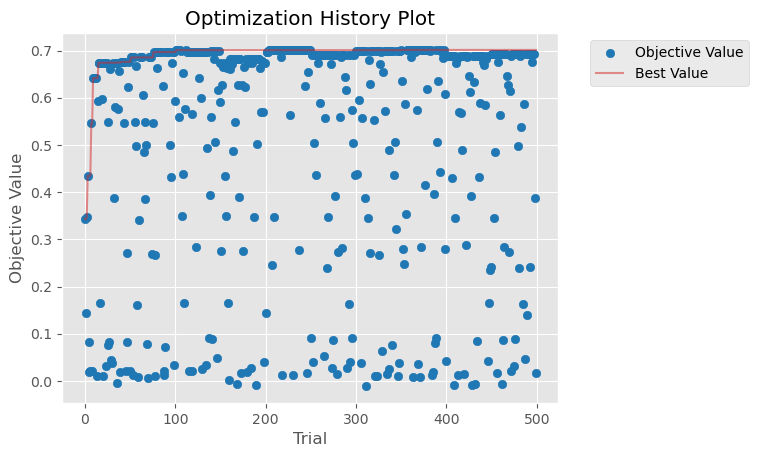

In [161]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [162]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [163]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.713829,0.024078
1,TP,166.600000,9.663218
2,TN,88.900000,6.773314
3,FP,24.500000,4.301163
4,FN,17.100000,4.040077
5,Accuracy,0.859982,0.025928
6,Precision,0.871384,0.024926
7,Sensitivity,0.906460,0.024376
8,Specificity,0.784040,0.034042
9,F1 score,0.888519,0.023524


In [164]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.720102,0.712450,0.690328,0.730473,0.672656,0.722036,0.693380,0.695743,0.702683,0.718044,0.705790,0.017870
1,TP,345.000000,334.000000,340.000000,336.000000,337.000000,344.000000,328.000000,331.000000,317.000000,339.000000,335.100000,8.279157
2,TN,167.000000,170.000000,173.000000,181.000000,169.000000,174.000000,170.000000,163.000000,185.000000,184.000000,173.600000,7.426679
3,FP,45.000000,60.000000,49.000000,45.000000,62.000000,44.000000,58.000000,57.000000,57.000000,47.000000,52.400000,7.026932
4,FN,38.000000,31.000000,33.000000,33.000000,27.000000,33.000000,39.000000,44.000000,36.000000,25.000000,33.900000,5.646041
5,Accuracy,0.860504,0.847059,0.862185,0.868908,0.850420,0.870588,0.836975,0.830252,0.843697,0.878992,0.854958,0.015787
6,Precision,0.884615,0.847716,0.874036,0.881890,0.844612,0.886598,0.849741,0.853093,0.847594,0.878238,0.864813,0.017591
7,Sensitivity,0.900783,0.915068,0.911528,0.910569,0.925824,0.912467,0.893733,0.882667,0.898017,0.931319,0.908198,0.014709
8,Specificity,0.787700,0.739100,0.779300,0.800900,0.731600,0.798200,0.745600,0.740900,0.764500,0.796500,0.768430,0.027344
9,F1 score,0.892626,0.880105,0.892388,0.896000,0.883355,0.899346,0.871182,0.867628,0.872077,0.904000,0.885871,0.012821


In [165]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
svm_5preds = pd.concat([chembl_id, svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,CHEMBL4084049,0,6.26,9.219488,9.122708,9.520794,9.181708,9.237545,8.757041,1.123783
1,CHEMBL2178343,1,5.96,5.947284,6.075208,5.932128,5.939215,6.001966,5.975967,0.049791
2,CHEMBL454672,2,6.80,6.532088,6.535762,6.586912,6.467704,6.661123,6.597265,0.108092
3,CHEMBL4299417,3,8.14,7.290831,7.387670,7.741231,7.824869,7.421946,7.634424,0.296472
4,CHEMBL3692580,4,5.24,5.860366,5.826391,5.840933,5.966441,6.199734,5.822311,0.289862
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL3775269,2966,7.40,6.935708,6.871409,6.671857,6.892574,7.018283,6.964972,0.220930
2967,CHEMBL3339019,2967,8.07,7.971295,7.873109,7.988693,7.968394,7.985231,7.976120,0.057371
2968,CHEMBL3771312,2968,6.52,6.000765,5.873185,5.965293,5.988346,5.834441,6.030338,0.227197
2969,CHEMBL3589701,2969,6.49,6.596601,6.639120,6.586621,6.640874,6.396958,6.558362,0.087859


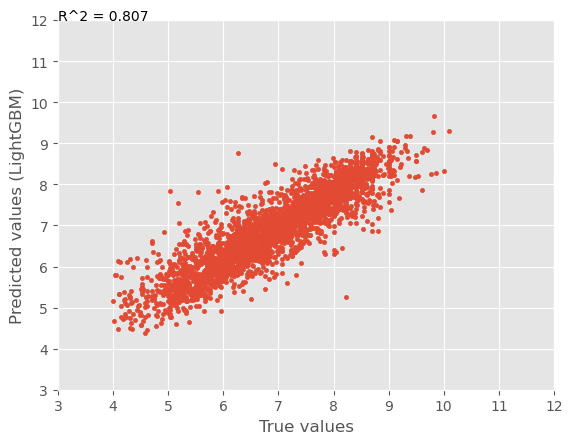

In [166]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'])), (3, 12))
plt.show()

In [167]:
#cross valide using this optimized SVR 
svm_baseline_CVscore = cross_val_score(svm_reg, X, Y, cv=10, scoring="r2")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="r2")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="r2")
print("SVM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model r2_score 0.6914 with a standard deviation of 0.0222
SVM optimized model r2_score 0.7129 with a standard deviation of 0.0207


In [168]:
joblib.dump(svm_reg, "OUTPUT/svm_reg.joblib")
#joblib.dump(optimized_svm, "OUTPUT/optimized_svm.joblib")
joblib.dump(optimizedCV_svm, "OUTPUT/optimizedCV_svm.joblib")

['OUTPUT/optimizedCV_svm.joblib']

In [169]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/TestSet_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_rf_test.to_excel(writer, sheet_name="RF", )
    mat_met_lgbm_test.to_excel(writer, sheet_name="LGBM", )
    mat_met_xgb_test.to_excel(writer, sheet_name="XGB", )
    mat_met_knn_test.to_excel(writer, sheet_name="KNN", )
    mat_met_svm_test.to_excel(writer, sheet_name="SVM", )
   

In [170]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_optimized_rf.to_excel(writer, sheet_name="RF", )
    mat_met_optimized_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_optimized_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_optimized_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_optimized_svm.to_excel(writer, sheet_name="SVM", )

In [171]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/PredResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    rf_5preds.to_excel(writer, sheet_name="RF", )
    lgbm_5preds.to_excel(writer, sheet_name="LGBM", )
    xgb_5preds.to_excel(writer, sheet_name="XGB", )
    knn_5preds.to_excel(writer, sheet_name="KNN", )
    svm_5preds.to_excel(writer, sheet_name="SVM", )